# <span style='color:SteelBlue'>P7 - Implémentez un modèle de scoring</span>

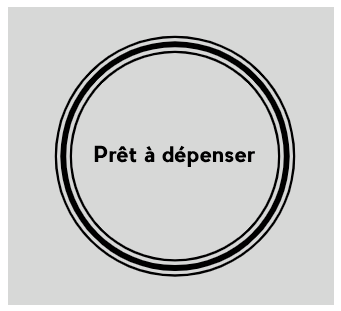

 # <span class='bg-primary'>P7_01_04 - FEATURES SELECTION</span>

Ce notebook traite de la 'features sélection' des jeux de données des dataframes **train_set** et **test_set** composés des pré-processing (nettoyage, feature engineering)/aggrégations de tous les fichiers mis à notre disposition:

- **bureau.csv**,
- **bureau_balance.csv**,
- **credit_card_balance.csv**,
- **installments_payments.csv**,
- **POS_CASH_balance.csv**,
- **previous_application.csv**

En particulier :

- **Feature selection** : outre la génération de caractéristiques importantes/utiles, il est également essentiel de supprimer les caractéristiques redondantes et bruyantes. Si nous introduisons des déchets/bruits dans notre modèle d'apprentissage automatique, il retournera des déchets/bruits. Nous devons donc trouver de bonnes techniques de sélection des caractéristiques les plus importantes et discriminantes pour notre problématique.

***
Sources
***
Kernel Kaggle sur Home Credit :
- Feature sélection avec Lightgbm : [Source](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
- Feature sélection avec BORUTA : [Source](https://www.kaggle.com/rsmits/feature-selection-with-boruta).
- Feature sélection avec BOOSTAROOTA : [Source](https://github.com/Murfin/nn_project/blob/master/NN%20project%20notebook%20ver.%202.ipynb)

## <span style='background:Thistle'>Sommaire du notebook</span> 

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## <span style='background:Thistle'>1. Introduction</span>

*****
**Mission**
*****
**Développer un modèle de scoring de la probabilité de défaut de paiement du client** pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières...).

*****
**Objectifs**
*****
- analyser le jeu de données,
- Construire **un modèle de scoring** qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique,
- réaliser un **dashboard interactif** permettant aux chargés de clientèles d'expliquer de manière transparente la décision d'octroi ou non de crédit

*****
**Sources**
*****
- [Jeu de données](https://www.kaggle.com/c/home-credit-default-risk/data)

Le **Kernel Kaggle** utilisé pour l'analyse exploratoire ayant l'EDA le plus de commentaires et effectuant une analyse exploratoire complète sur toutes les fichiers csv mis à notre disposition a été livré par **Rishabh Rao** (Student at -Jaipur, Rajasthan, India).
- [Kernel Kaggle Rishabh Rao](https://www.kaggle.com/rishabhrao/home-credit-default-risk-extensive-eda)

Ce travail est complété par l'auteur par une présentation sur le site medium.com :
[Explications](https://medium.com/thecyphy/home-credit-default-risk-part-1-3bfe3c7ddd7a)

Les fonctions python utilisées pour l'EDA sont extraites du [github](https://github.com/rishabhrao1997/Home-Credit-Default-Risk) et stockées dans la librairie *EDA_KERNEL_FONCTIONS.py*.

In [2]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
import jyquickhelper
import numpy as np
import pandas as pd
import os
import outils_data
import outils_preprocessing
import eda_kernel_fonctions
import pickle

# Modelisation
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Features selection
from boruta import BorutaPy
from BorutaShap import BorutaShap

# Warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# Chargement à chaud des librairies personnelles
%load_ext autoreload
%autoreload 2
# Valide code pep8
%load_ext pycodestyle_magic
%pycodestyle_on
# %pycodestyle_off

# Versions
print('Version des librairies utilisées :')
print('jyquickhelper         : ' + jyquickhelper.__version__)
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Lightgbm              : ' + lgb.__version__)
print('Outils dataframe      : ' + outils_data.__version__)
print('Outils pré-processing : ' + outils_preprocessing.__version__)
print('EDA Kernel fonctions  : ' + eda_kernel_fonctions.__version__)
now = datetime.now().isoformat()
print('Lancé le           : ' + now)

Version des librairies utilisées :
jyquickhelper         : 0.4.220
Python                : 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
NumPy                 : 1.19.5
Pandas                : 1.2.4
Lightgbm              : 3.1.1
Outils dataframe      : 0.0.4
Outils pré-processing : 0.0.0
EDA Kernel fonctions  : 0.0.0
Lancé le           : 2021-07-27T11:20:24.317781


In [3]:
dico_pd_option = {
    'display.max_rows': 400,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

## <span style='background:Thistle'>2. Chargement des jeux de données</span>

**Chargement des dataframes nettoyés**

In [4]:
fic_sav_train_set = \
    '../sauvegarde/pre-processing/train_set_preproc.pickle'
# Chargement de train_set
with open(fic_sav_train_set, 'rb') as df_appli_train_set:
    train_set = pickle.load(df_appli_train_set)
train_set.shape

(307507, 615)

In [5]:
fic_sav_appli_train_imp1 = \
    '../sauvegarde/pre-processing/train_imp1_set_preproc.pickle'
# Chargement de train_imp1_set
with open(fic_sav_appli_train_imp1, 'rb') as df_appli_train_imp1_set:
    train_imp1_set = pickle.load(df_appli_train_imp1_set)
train_imp1_set.shape

(307507, 622)

In [6]:
fic_sav_appli_train_imp2 = \
    '../sauvegarde/pre-processing/train_imp2_set_preproc.pickle'
# Chargement de train_imp2_set
with open(fic_sav_appli_train_imp2, 'rb') as df_appli_train_imp2_set:
    train_imp2_set = pickle.load(df_appli_train_imp2_set)
train_imp2_set.shape

(307507, 614)

In [7]:
fic_sav_test_set = \
    '../sauvegarde/pre-processing/test_set_preproc.pickle'
# Chargement de test_set
with open(fic_sav_test_set, 'rb') as df_appli_test_set:
    test_set = pickle.load(df_appli_test_set)
test_set.shape

(48744, 614)

In [8]:
fic_sav_appli_test_imp1 = \
    '../sauvegarde/pre-processing/test_imp1_set_preproc.pickle'
# Chargement de test_imp1_set
with open(fic_sav_appli_test_imp1, 'rb') as df_appli_test_imp1_set:
    test_imp1_set = pickle.load(df_appli_test_imp1_set)
test_imp1_set.shape

(48744, 621)

In [9]:
fic_sav_appli_test_imp2 = \
    '../sauvegarde/pre-processing/test_imp2_set_preproc.pickle'
# Chargement de test_imp2_set
with open(fic_sav_appli_test_imp2, 'rb') as df_appli_test_imp2_set:
    test_imp2_set = pickle.load(df_appli_test_imp2_set)
test_imp2_set.shape

(48744, 613)

## <span style='background:Thistle'>3. Features selection</span> 

### <span style='background:PowderBlue'>3.1. Features selection : avec LIGHTGBM</span>

- Extrait du Kernel Kaggle : [Source](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
- Le but est de conserver uniquement les variables les plus pertinentes en utilisant les features importance déterminée par un modèle, Lightgbm dans notre cas.

<span style='background:Moccasin'>**Train_set/test_set**</span>

**Préparation des dataframes de travail**

In [10]:
# Résumé des variables qualitatives
desc_train_set = outils_data.description_variables(train_set)
desc_train_set

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_GOODS_DIFF,INCOME_EXT_RATIO,LAST_PHONE_EMPLOYED_RATIO,CAR_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,EXT_SOURCE_SUM,EXT_SOURCE_MAX,EXT_SOURCE_VAR,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,TARGET_NEIGHBORS_500_MEAN,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_GROUP_OF_PEOPLE,NAME_TYPE_SUITE_OTHER_A,NAME_TYPE_SUITE_OTHER_B,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_INCOME_TYPE_BUSINESSMAN,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_STUDENT,NAME_INCOME_TYPE_UNEMPLOYED,NAME_INCOME_TYPE_WORKING,...,PREV_APP_DAYS_DECISION_MAX,PREV_APP_SELLERPLACE_AREA_MEAN,PREV_APP_SELLERPLACE_AREA_MIN,PREV_APP_CNT_PAYMENT_MEAN,PREV_APP_NAME_YIELD_GROUP_MEAN,PREV_APP_NAME_YIELD_GROUP_LAST,PREV_APP_DAYS_FIRST_DUE_SUM,PREV_APP_DAYS_LAST_DUE_MAX,PREV_APP_NFLAG_INSURED_ON_APPROVAL_SUM,PREV_APP_AMT_DECLINED_MEAN,PREV_APP_AMT_DECLINED_SUM,PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX,PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN,PREV_APP_AMT_CREDIT_GOODS_DIFF_SUM,PREV_APP_AMT_CREDIT_GOODS_DIFF_MEAN,PREV_APP_AMT_CREDIT_GOODS_DIFF_MAX,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MEAN,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MIN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MIN,PREV_APP_AMT_APPLICATION_TO_SELLERPLACE_AREA_MEAN,PREV_APP_ANNUITY_MEAN,PREV_APP_ANNUITY_GOODS_MEAN,PREV_APP_LOAN_RATE_MAX,PREV_APP_LOAN_RATE_MEAN,PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN,PREV_APP_AMT_INTEREST_MEAN,PREV_APP_INTEREST_SHARE_MEAN,PREV_APP_INTEREST_SHARE_MAX,PREV_APP_INTEREST_SHARE_MIN,PREV_APP_INTEREST_RATE_MAX,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MIN_MEAN,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MAX_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MAX_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MEAN_MEAN,PKPRET_BUREAU_BALANCE_STATUS_LAST_MEAN,PKPRET_BUREAU_BALANCE_STATUS_SUM_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST_MEAN,BUREAU_CREDIT_ACTIVE_ACTIVE_SUM,BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT,BUREAU_CREDIT_ACTIVE_ACTIVE_MEAN,BUREAU_CREDIT_ACTIVE_BAD_DEBT_SUM,BUREAU_CREDIT_ACTIVE_SOLD_SUM,BUREAU_CREDIT_ACTIVE_SOLD_MEAN,BUREAU_CREDIT_CURRENCY_CURRENCY_1_MEAN,BUREAU_CREDIT_CURRENCY_CURRENCY_2_SUM,BUREAU_CREDIT_CURRENCY_CURRENCY_3_SUM,BUREAU_CREDIT_CURRENCY_CURRENCY_3_MEAN,BUREAU_CREDIT_CURRENCY_CURRENCY_4_SUM,BUREAU_CREDIT_TYPE_ANOTHER_TYPE_OF_LOAN_SUM,BUREAU_CREDIT_TYPE_ANOTHER_TYPE_OF_LOAN_MEAN,BUREAU_CREDIT_TYPE_CAR_LOAN_SUM,BUREAU_CREDIT_TYPE_CAR_LOAN_MEAN,BUREAU_CREDIT_TYPE_CASH_LOAN_NON_EARMARKED__SUM,BUREAU_CREDIT_TYPE_CONSUMER_CREDIT_MEAN,BUREAU_CREDIT_TYPE_CREDIT_CARD_SUM,BUREAU_CREDIT_TYPE_INTERBANK_CREDIT_SU

In [11]:
# Dataframes de travail
train_fs_lgbm = train_set.copy()
print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
test_fs_lgbm = test_set.copy()
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 615)
test_fs_lgbm : (48744, 614)


In [12]:
# Sauvegarde des étiquettes car l'alignement supprimera
# cette variable.
train_fs_lgbm_labels = train_fs_lgbm['TARGET']

# Sauvegarde des identifiants
train_fs_lgbm_ids = train_fs_lgbm['SK_ID_CURR']
test_fs_lgbm_ids = test_fs_lgbm['SK_ID_CURR']

# Alignement des dataframes (suppression variable TARGET)
train_fs_lgbm, test_fs_lgbm = train_fs_lgbm.align(test_fs_lgbm,
                                                  join='inner', axis=1)

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_fs_lgbm = train_fs_lgbm.drop(columns=['SK_ID_CURR'])
test_fs_lgbm = test_fs_lgbm.drop(columns=['SK_ID_CURR'])

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 613)
test_fs_lgbm : (48744, 613)


**Modélisation**

***Premier passage***

In [13]:
# Initialiser un tableau vide pour contenir les features importance
feature_importances = np.zeros(train_fs_lgbm.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=10000,
                           class_weight='balanced')

In [14]:
# Entraînement du modèle deux fois pour éviter l'overfitting
for i in range(2):

    # Split en jeux d'entraînement et de validation
    train_features, valid_features, train_y, valid_y = \
        train_test_split(train_fs_lgbm, train_fs_lgbm_labels,
                         test_size=0.25, random_state=i)

    # Entraînement en utilisant early stopping
    model.fit(train_features, train_y,
              early_stopping_rounds=100,
              eval_set=[(valid_features, valid_y)],
              eval_metric='auc', verbose=200)

    # Sauvegarde des features importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.797616	valid_0's binary_logloss: 0.500258
Early stopping, best iteration is:
[173]	valid_0's auc: 0.798422	valid_0's binary_logloss: 0.50687
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.790252	valid_0's binary_logloss: 0.499792
Early stopping, best iteration is:
[166]	valid_0's auc: 0.790544	valid_0's binary_logloss: 0.508038


In [15]:
# Assurez-vous de faire la moyenne des features importance !
# puisque le modèle a été entraîné 2 fois
feature_importances = feature_importances / 2
df_fs_lightgbm = \
    pd.DataFrame({'feature': list(train_fs_lgbm.columns),
                  'importance': feature_importances}) \
    .sort_values('importance', ascending=False)

df_fs_lightgbm.head()

,feature,importance
85,TARGET_NEIGHBORS_500_MEAN,164.0
9,DAYS_BIRTH,99.0
254,INST_PAY_DAYS_PAYMENT_RATIO_MAX,92.5
26,EXT_SOURCE_1,75.5
78,EXT_SOURCE_SUM,73.5


In [18]:
# Exploration des variables avec zéro importance
# Find the features with zero importance
zero_features = \
    list(df_fs_lightgbm[df_fs_lightgbm['importance'] == 0.0]['feature'])
print(f'{len(zero_features)} variables avec 0.0 importance :\n')
zero_features

201 variables avec 0.0 importance :



['FLAG_DOCUMENT_13',
 'ORGANIZATION_TYPE_MOBILE',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'ORGANIZATION_TYPE_POSTAL',
 'FLAG_DOCUMENT_17',
 'CCB_NAME_CONTRACT_STATUS_SIGNED_SUM',
 'CCB_NAME_CONTRACT_STATUS_SENT_PROPOSAL_SUM',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_19',
 'CCB_NAME_CONTRACT_STATUS_DEMAND_SUM',
 'CCB_NAME_CONTRACT_STATUS_REFUSED_SUM',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'NAME_TYPE_SUITE_GROUP_OF_PEOPLE',
 'CCB_CNT_DRAWINGS_OTHER_CURRENT_MAX',
 'ORGANIZATION_TYPE_INSURANCE',
 'ORGANIZATION_TYPE_EMERGENCY',
 'NAME_HOUSING_TYPE_CO_OP_APARTMENT',
 'ORGANIZATION_TYPE_GOVERNMENT',
 'NAME_FAMILY_STATUS_WIDOW',
 'ORGANIZATION_TYPE_HOUSING',
 'ORGANIZATION_TYPE_INDUSTRY_TYPE_1',
 'ORGANIZATION_TYPE_INDUSTRY_TYPE_10',
 'ORGANIZATION_TYPE_INDUSTRY_TYPE_11',
 'ORGANIZATION_TYPE_INDUSTRY_TYPE_12',
 'ORGANIZATION_TYPE_INDUSTRY_TYPE_13',
 'ORGANIZATION_TYPE_INDUSTRY_TYPE_2',
 'ORGANIZATION_TYPE_INDUSTRY_TYPE_4',
 'NAME_INCOME_T

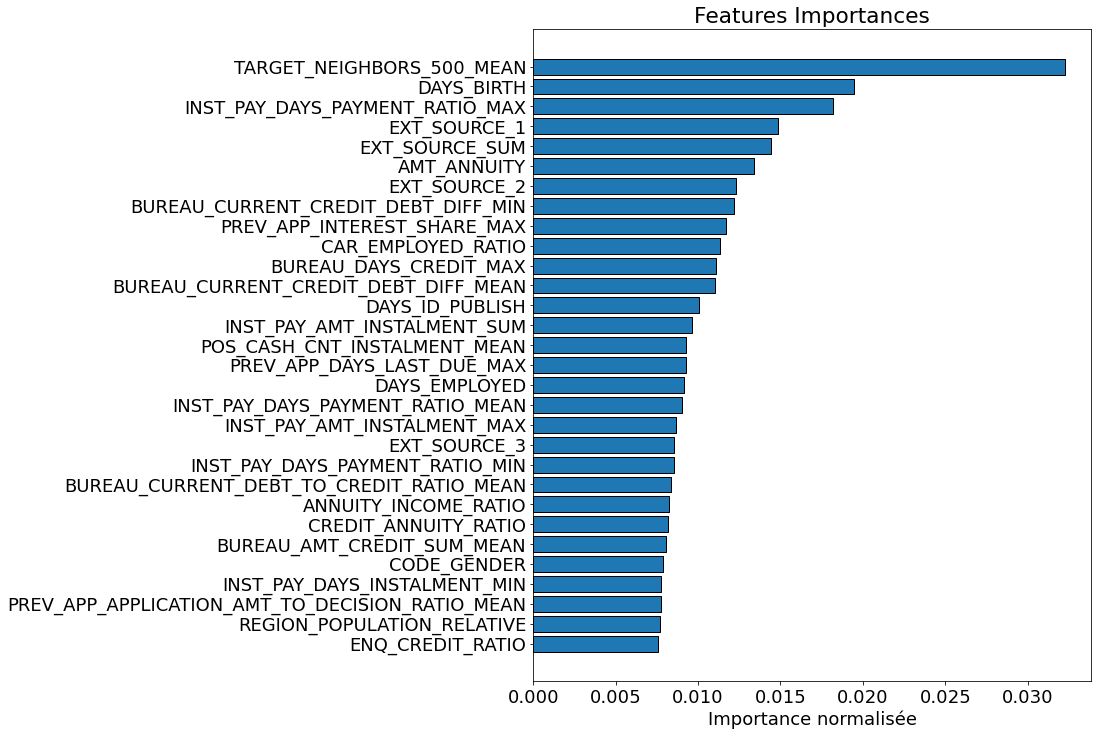

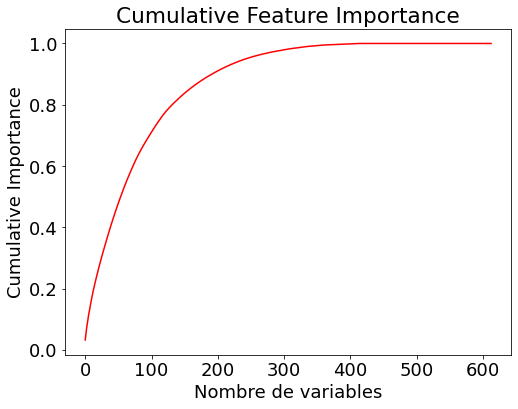

192 variables nécessaires pour 0.90 de cumulative importance


In [21]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_lightgbm)

In [20]:
# Suppression des variables avec zéro importance
train_fs_lgbm = train_fs_lgbm.drop(columns=zero_features)
test_fs_lgbm = test_fs_lgbm.drop(columns=zero_features)

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 412)
test_fs_lgbm : (48744, 412)


***Second passage***

In [23]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_2, df_fs_lightgbm_2 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_fs_lgbm,
                                       train_fs_lgbm_labels)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.796766	valid_0's binary_logloss: 0.501436
Early stopping, best iteration is:
[150]	valid_0's auc: 0.797526	valid_0's binary_logloss: 0.513425
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.791329	valid_0's binary_logloss: 0.499126
Early stopping, best iteration is:
[120]	valid_0's auc: 0.792486	valid_0's binary_logloss: 0.519079

There are 37 features with 0.0 importance


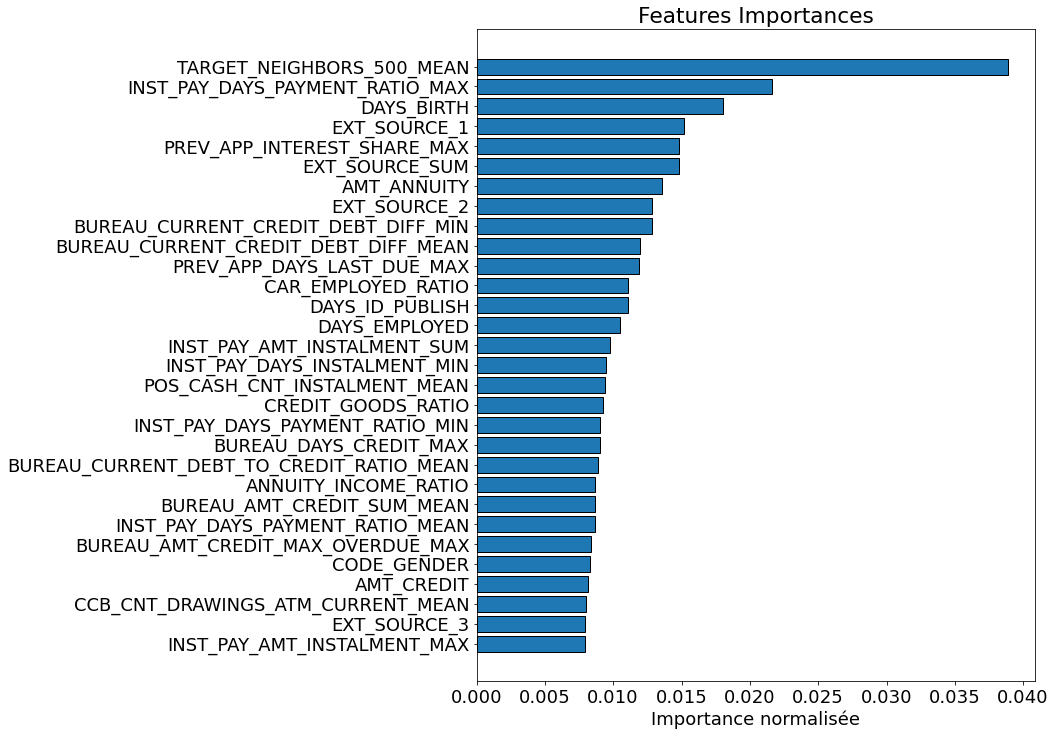

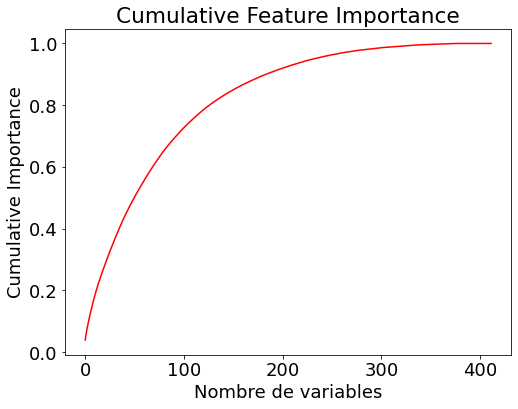

184 variables nécessaires pour 0.90 de cumulative importance


In [30]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm_2 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_lightgbm_2)

In [31]:
# Suppression des variables avec zéro importance
train_fs_lgbm = train_fs_lgbm.drop(columns=zero_features_2)
test_fs_lgbm = test_fs_lgbm.drop(columns=zero_features_2)

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 375)
test_fs_lgbm : (48744, 375)


***Troisième passage***

In [33]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_3, df_fs_lightgbm_3 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_fs_lgbm,
                                       train_fs_lgbm_labels)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.797326	valid_0's binary_logloss: 0.501232
Early stopping, best iteration is:
[176]	valid_0's auc: 0.797696	valid_0's binary_logloss: 0.507638
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.791781	valid_0's binary_logloss: 0.499793
Early stopping, best iteration is:
[135]	valid_0's auc: 0.791876	valid_0's binary_logloss: 0.515951

There are 12 features with 0.0 importance


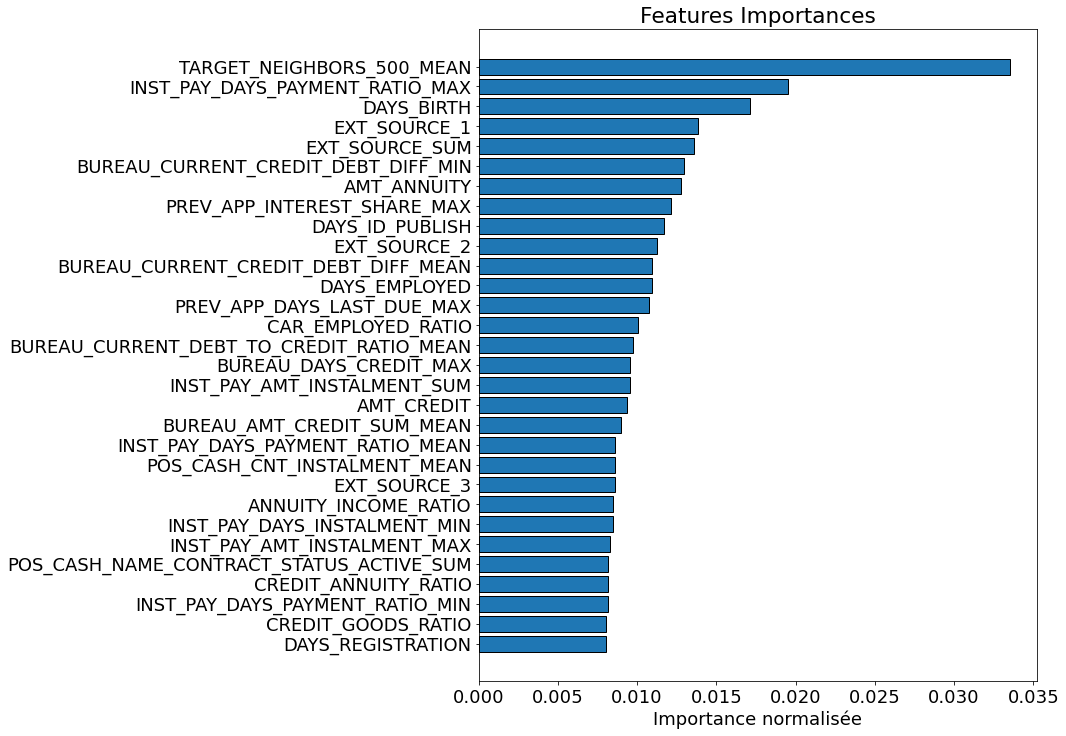

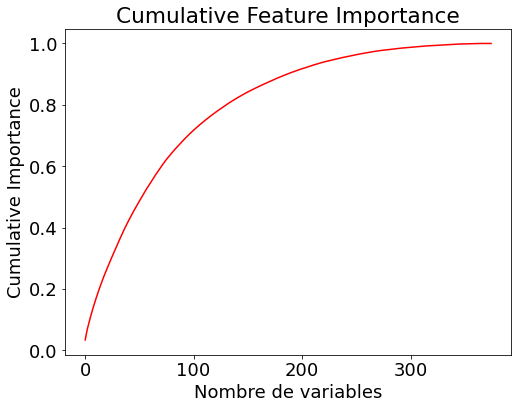

187 variables nécessaires pour 0.90 de cumulative importance


In [35]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm_3 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_lightgbm_3)

In [36]:
# Suppression des variables avec zéro importance
train_fs_lgbm = train_fs_lgbm.drop(columns=zero_features_3)
test_fs_lgbm = test_fs_lgbm.drop(columns=zero_features_3)

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 363)
test_fs_lgbm : (48744, 363)


***Quatrième passage***

In [37]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_4, df_fs_lightgbm_4 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_fs_lgbm,
                                       train_fs_lgbm_labels)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.796991	valid_0's binary_logloss: 0.501929
Early stopping, best iteration is:
[176]	valid_0's auc: 0.797696	valid_0's binary_logloss: 0.507638
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.791296	valid_0's binary_logloss: 0.499553
Early stopping, best iteration is:
[135]	valid_0's auc: 0.791876	valid_0's binary_logloss: 0.515951

There are 0 features with 0.0 importance


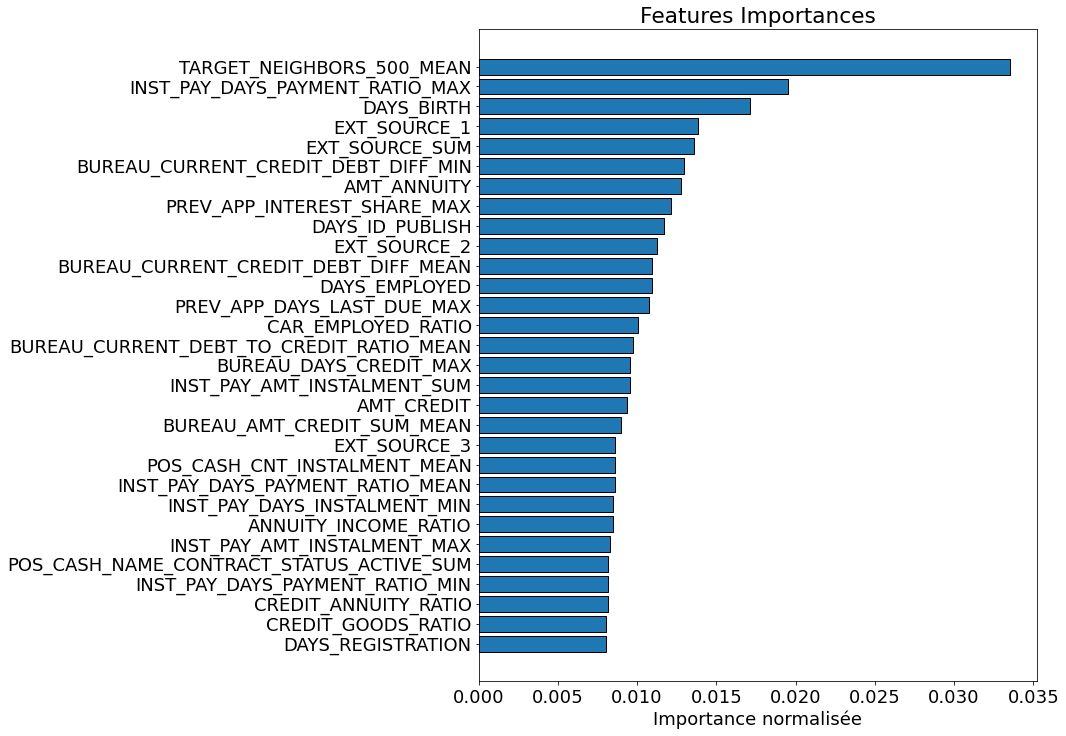

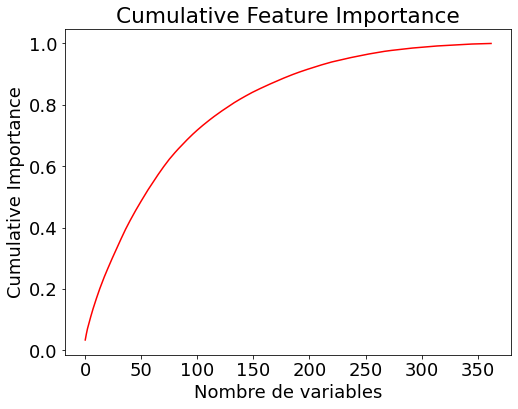

187 variables nécessaires pour 0.90 de cumulative importance


In [38]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm_4 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_lightgbm_4)

**Reconstitution des dataframes**

In [179]:
train_fs_lgbm['TARGET'] = train_fs_lgbm_labels
train_fs_lgbm['SK_ID_CURR'] = train_fs_lgbm_ids
print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
test_fs_lgbm['SK_ID_CURR'] = test_fs_lgbm_ids
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 365)
test_fs_lgbm : (48744, 364)


**Sauvegarde**

In [80]:
# Sauvegarde des features importances avec lightgbm
fic_sav_fs_lightgbm = \
    '../sauvegarde/features-selection/fs_lightgbm.pickle'
with open(fic_sav_fs_lightgbm, 'wb') as f:
    pickle.dump(df_fs_lightgbm_4, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [10]:
# Chargement des features importance de ligthgbm
fic_sav_fs_train_set = \
    '../sauvegarde/features-selection/fs_lightgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_train_set, 'rb') as df_fs_train_set:
    df_fs_lightgbm = pickle.load(df_fs_train_set)
df_fs_lightgbm.shape

(363, 2)

In [11]:
# Sauvegarde du nombre de features importance
df_fs_train_set = pd.DataFrame({})
df_fs_train_set = \
    outils_preprocessing.tracer_features_importance(df_fs_lightgbm,
                                                    df_fs_train_set,
                                                    'train_set',
                                                    'lightgbm')

train_set - lightgbm : 363 variables importantes conservées


<span style='background:Moccasin'>**Train_imp1_set/test_imp1_set**</span>

**Préparation des dataframes de travail**

In [129]:
# Résumé des variables qualitatives
desc_train_imp1_set = outils_data.description_variables(train_imp1_set)
desc_train_imp1_set

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_GOODS_DIFF,INCOME_EXT_RATIO,CREDIT_EXT_RATIO,LAST_PHONE_EMPLOYED_RATIO,CAR_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,EXT_SOURCE_SUM,EXT_SOURCE_MUL,EXT_SOURCE_MAX,EXT_SOURCE_VAR,INCOME_APARTMENT_AVG_MUL,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,TARGET_NEIGHBORS_500_MEAN,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_GROUP_OF_PEOPLE,NAME_TYPE_SUITE_OTHER_A,NAME_TYPE_SUITE_OTHER_B,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_TYPE_SUITE_UNACCOMPANIED,NAME_TYPE_SUITE_XNA,NAME_INCOME_TYPE_BUSINESSMAN,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_STUDENT,NAME_INCOME_TYPE_UNEMPLOYED,NAME_INCOME_TYPE_WORKING,NAME_INCOME_TYPE_XNA,NAME_EDUCATION_TYPE_ACADEMIC_DEGREE,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,NAME_EDUCATION_TYPE_INCOMPLETE_HIGHER,NAME_EDUCATION_TYPE_LOWER_SECONDARY,NAME_FAMILY_STATUS_CIVIL_MARRIAGE,NAME_FAMILY_STATUS_MARRIED,NAME_FAMILY_STATUS_SEPARATED,NAME_FAMILY_STATUS_SINGLE_NOT_MARRIED,NAME_FAMILY_STATUS_WIDOW,NAME_FAMILY_STATUS_XNA,NAME_HOUSING_TYPE_CO_OP_APARTMENT,NAME_HOUSING_TYPE_HOUSE_APARTMENT,NAME_HOUSING_TYPE_MUNICIPAL_APARTMENT,NAME_HOUSING_TYPE_OFFICE_APARTMENT,NAME_HOUSING_TYPE_RENTED_APARTMENT,NAME_HOUSING_TYPE_WITH_PARENTS,OCCUPATION_TYPE_ACCOUNTANTS,OCCUPATION_TYPE_CLEANING_STAFF,OCCUPATION_TYPE_COOKING_STAFF,OCCUPATION_TYPE_CORE_STAFF,OCCUPATION_TYPE_DRIVERS,OCCUPATION_TYPE_HR_STAFF,OCCUPATION_TYPE_HIGH_SKILL_TECH_STAFF,OCCUPATION_TYPE_IT_STAFF,OCCUPATION_TYPE_LABORERS,OCCUPATION_TYPE_LOW_SKILL_LABORERS,OCCUPATION_TYPE_MANAGERS,OCCUPATION_TYPE_MEDICINE_STAFF,OCCUPATION_TYPE_PRIVATE_SERVICE_STAFF,OCCUPATION_TYPE_REALTY_AGENTS,OCCUPATION_TYPE_SALES_STAFF,OCCUPATION_TYPE_SECRETARIES,OCCUPATION_TYPE_SECURITY_STAFF,OCCUPATION_TYPE_WAITERS_BARMEN_STAFF,OCCUPATION_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_ADVERTISING,ORGANIZATION_TYPE_AGRICULTURE,ORGANIZATION_TYPE_BANK,ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_1,ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_2,ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_3,ORGANIZATION_TYPE_CLEANING,ORGANIZATION_TYPE_CONSTRUCTION,ORGANIZATION_TYPE_CULTURE,ORGANIZATION_TYPE_ELECTRICITY,ORGANIZATION_TYPE_EMERGENCY,ORGANIZATION_TYPE_GOVERNMENT,ORGANIZATION_TYPE_HOTEL,ORGANIZATION_TYPE_HOUSING,ORGANIZATION_TYPE_INDUSTRY_TYPE_1,ORGANIZATION_TYPE_INDUSTRY_TYPE_10,ORGANIZATION_TYPE_INDUSTRY_TYPE_11,ORGANIZATION_TYPE_INDUSTRY_TYPE_12,ORGANIZATION_TYPE_INDUSTRY_TYPE_13,ORGANIZATION_TYPE_INDUSTRY_TYPE_2,ORGANIZATION_TYPE_INDUS

In [130]:
# Dataframes de travail
train_imp1_fs_lgbm = train_imp1_set.copy()
print(f'train_imp1_fs_lgbm : {train_imp1_fs_lgbm.shape}')
test_imp1_fs_lgbm = test_imp1_set.copy()
print(f'test_imp1_fs_lgbm : {test_imp1_fs_lgbm.shape}')

train_imp1_fs_lgbm : (307507, 622)
test_imp1_fs_lgbm : (48744, 621)


In [131]:
# Sauvegarde des étiquettes car l'alignement supprimera
# cette variable.
train_imp1_fs_lgbm_labels = train_imp1_fs_lgbm['TARGET']

# Sauvegarde des identifiants
train_imp1_fs_lgbm_ids = train_imp1_fs_lgbm['SK_ID_CURR']
test_imp1_fs_lgbm_ids = test_imp1_fs_lgbm['SK_ID_CURR']

# Alignement des dataframes (suppression variable TARGET)
train_imp1_fs_lgbm, test_imp1_fs_lgbm = \
    train_imp1_fs_lgbm.align(test_imp1_fs_lgbm, join='inner', axis=1)

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_imp1_fs_lgbm = train_imp1_fs_lgbm.drop(columns=['SK_ID_CURR'])
test_imp1_fs_lgbm = test_imp1_fs_lgbm.drop(columns=['SK_ID_CURR'])

print(f'train_imp1_fs_lgbm : {train_imp1_fs_lgbm.shape}')
print(f'test_imp1_fs_lgbm : {test_imp1_fs_lgbm.shape}')

train_imp1_fs_lgbm : (307507, 620)
test_imp1_fs_lgbm : (48744, 620)


**Modélisation**

***Premier passage***

In [132]:
# Initialiser un tableau vide pour contenir les features importance
feature_importances_imp1 = np.zeros(train_imp1_fs_lgbm.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=10000,
                           class_weight='balanced')

In [133]:
# Entraînement du modèle deux fois pour éviter l'overfitting
for i in range(2):

    # Split en jeux d'entraînement et de validation
    train_imp1_features, valid_imp1_features, train_imp1_y, valid_imp1_y = \
        train_test_split(train_imp1_fs_lgbm, train_imp1_fs_lgbm_labels,
                         test_size=0.25, random_state=i)

    # Entraînement en utilisant early stopping
    model.fit(train_imp1_features, train_imp1_y,
              early_stopping_rounds=100,
              eval_set=[(valid_imp1_features, valid_imp1_y)],
              eval_metric='auc', verbose=200)

    # Sauvegarde des features importances
    feature_importances_imp1 += model.feature_importances_

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.794589	valid_0's binary_logloss: 0.503026
Early stopping, best iteration is:
[130]	valid_0's auc: 0.795517	valid_0's binary_logloss: 0.520689
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.790534	valid_0's binary_logloss: 0.50109
Early stopping, best iteration is:
[160]	valid_0's auc: 0.791108	valid_0's binary_logloss: 0.510633


In [134]:
# Assurez-vous de faire la moyenne des features importance !
# puisque le modèle a été entraîné 2 fois
feature_importances_imp1 = feature_importances_imp1 / 2
df_fs_imp1_lightgbm = \
    pd.DataFrame({'feature': list(train_imp1_fs_lgbm.columns),
                  'importance': feature_importances_imp1}) \
    .sort_values('importance', ascending=False)

df_fs_imp1_lightgbm.head()

,feature,importance
87,TARGET_NEIGHBORS_500_MEAN,159.5
9,DAYS_BIRTH,92.5
261,INST_PAY_DAYS_PAYMENT_RATIO_MAX,85.0
27,EXT_SOURCE_2,72.0
10,DAYS_EMPLOYED,69.0


In [135]:
# Exploration des variables avec zéro importance
# Find the features with zero importance
zero_features_imp1 = \
    list(df_fs_imp1_lightgbm[df_fs_imp1_lightgbm['importance'] == 0.0][
    'feature'])
print(f'{len(zero_features_imp1)} variables avec 0.0 importance :\n')
zero_features_imp1

205 variables avec 0.0 importance :



['FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_12',
 'ORGANIZATION_TYPE_MOBILE',
 'ORGANIZATION_TYPE_OTHER',
 'CCB_NAME_CONTRACT_STATUS_DEMAND_SUM',
 'WALLSMATERIAL_MODE_WOODEN',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'CCB_NAME_CONTRACT_STATUS_ACTIVE_MEAN',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_19',
 'CCB_NAME_CONTRACT_STATUS_REFUSED_SUM',
 'FLAG_DOCUMENT_17',
 'CCB_NAME_CONTRACT_STATUS_APPROVED_SUM',
 'CCB_NAME_CONTRACT_STATUS_SENT_PROPOSAL_SUM',
 'OCCUPATION_TYPE_PRIVATE_SERVICE_STAFF',
 'CCB_CNT_DRAWINGS_OTHER_CURRENT_MAX',
 'ORGANIZATION_TYPE_INSURANCE',
 'ORGANIZATION_TYPE_ELECTRICITY',
 'PREV_APP_NFLAG_LAST_APPL_IN_DAY_MEAN',
 'ORGANIZATION_TYPE_EMERGENCY',
 'ORGANIZATION_TYPE_INDUSTRY_TYPE_1',
 'NAME_INCOME_TYPE_XNA',
 'NAME_INCOME_TYPE_UNEMPLOYED',
 'NAME_INCOME_TYPE_STUDENT',
 'ORGANIZATION_TYPE_INDUSTRY_TYPE_10',
 'NAME_INCOME_TYPE_BUSINESSMAN',
 'ORGANIZATION_TYPE_INDUSTRY_TYPE_12',
 'ORGANIZATION_TYPE_INDUSTRY_TYPE_13',
 'ORGANIZATION_TYPE_INDUSTRY_T

5:5: E122 8


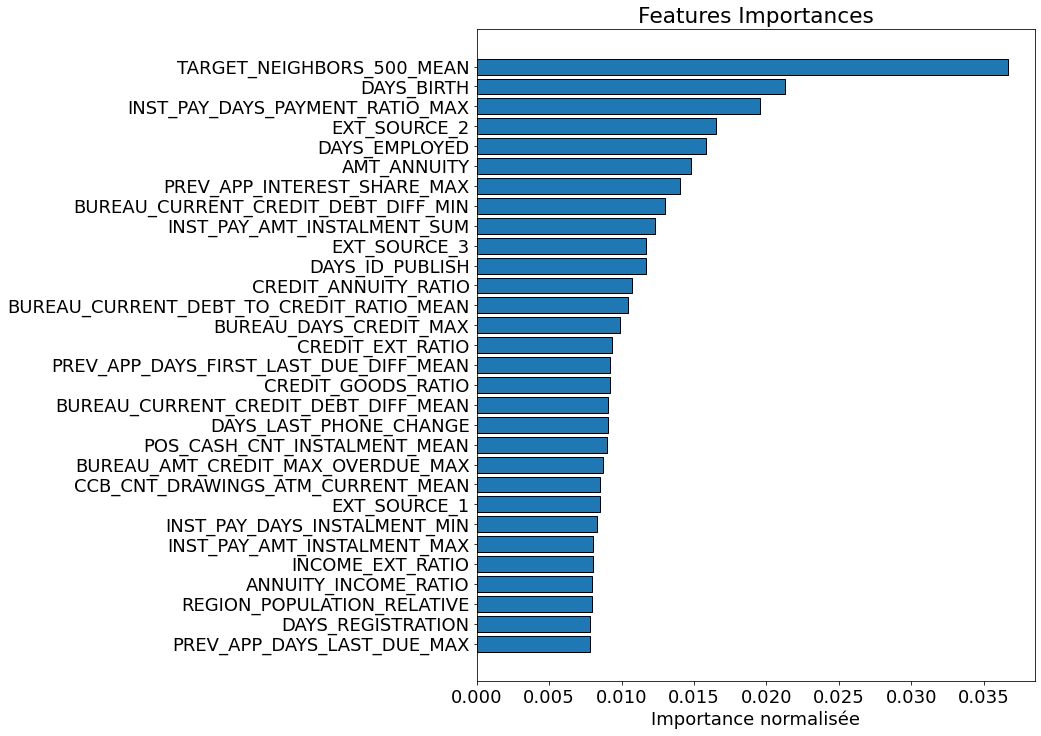

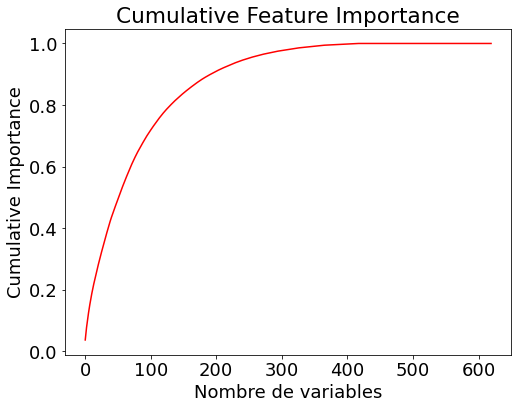

193 variables nécessaires pour 0.90 de cumulative importance


In [136]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_imp1_lightgbm_norm = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_imp1_lightgbm)

In [137]:
# Suppression des variables avec zéro importance
train_imp1_fs_lgbm = train_imp1_fs_lgbm.drop(columns=zero_features_imp1)
test_imp1_fs_lgbm = test_imp1_fs_lgbm.drop(columns=zero_features_imp1)

print(f'train_imp1_fs_lgbm : {train_imp1_fs_lgbm.shape}')
print(f'test_imp1_fs_lgbm : {test_imp1_fs_lgbm.shape}')

train_imp1_fs_lgbm : (307507, 415)
test_imp1_fs_lgbm : (48744, 415)


***Second passage***

In [138]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_imp1_2, df_fs_imp1_lightgbm_2 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_imp1_fs_lgbm,
                                       train_imp1_fs_lgbm_labels)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.796189	valid_0's binary_logloss: 0.502761
Early stopping, best iteration is:
[136]	valid_0's auc: 0.796802	valid_0's binary_logloss: 0.518725
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.790726	valid_0's binary_logloss: 0.500598
Early stopping, best iteration is:
[146]	valid_0's auc: 0.791508	valid_0's binary_logloss: 0.513704

There are 31 features with 0.0 importance


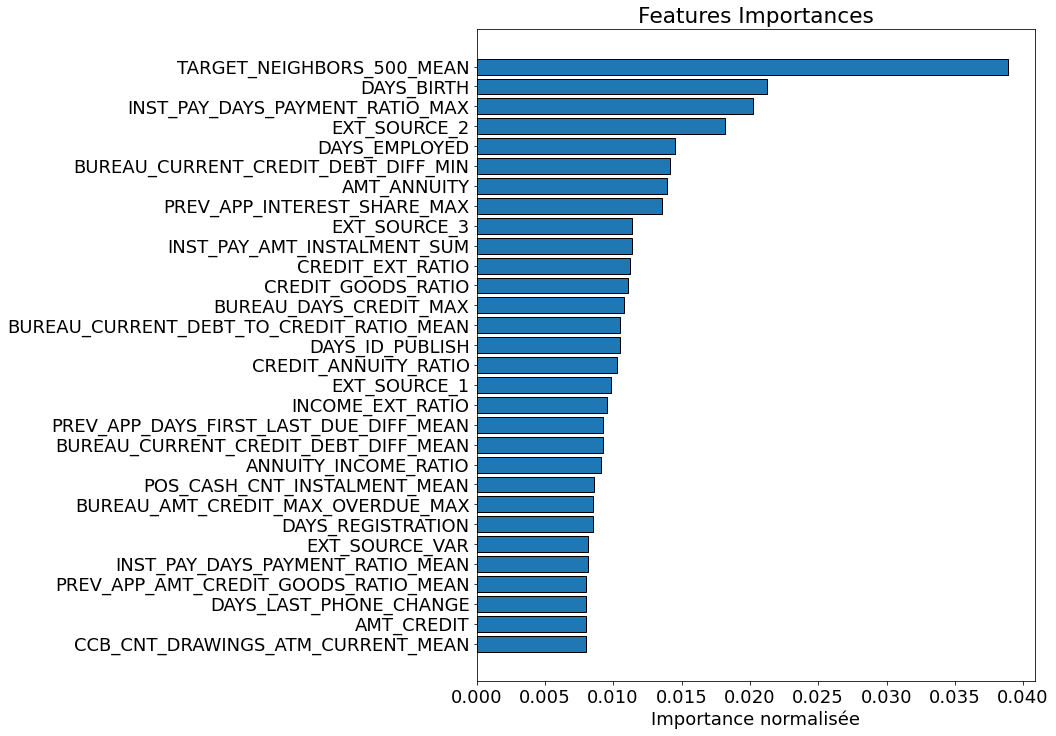

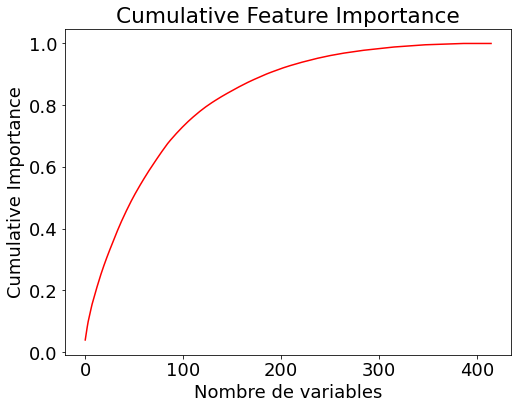

186 variables nécessaires pour 0.90 de cumulative importance


In [139]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_imp1_lightgbm_norm_2 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_imp1_lightgbm_2)

In [140]:
# Suppression des variables avec zéro importance
train_imp1_fs_lgbm = train_imp1_fs_lgbm.drop(columns=zero_features_imp1_2)
test_imp1_fs_lgbm = test_imp1_fs_lgbm.drop(columns=zero_features_imp1_2)

print(f'train_imp1_fs_lgbm : {train_imp1_fs_lgbm.shape}')
print(f'test_imp1_fs_lgbm : {test_imp1_fs_lgbm.shape}')

train_imp1_fs_lgbm : (307507, 384)
test_imp1_fs_lgbm : (48744, 384)


***Troisième passage***

In [141]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_imp1_3, df_fs_imp1_lightgbm_3 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_imp1_fs_lgbm,
                                       train_imp1_fs_lgbm_labels)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.795843	valid_0's binary_logloss: 0.502511
Early stopping, best iteration is:
[136]	valid_0's auc: 0.796802	valid_0's binary_logloss: 0.518725
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.791409	valid_0's binary_logloss: 0.50047
Early stopping, best iteration is:
[146]	valid_0's auc: 0.791508	valid_0's binary_logloss: 0.513704

There are 0 features with 0.0 importance


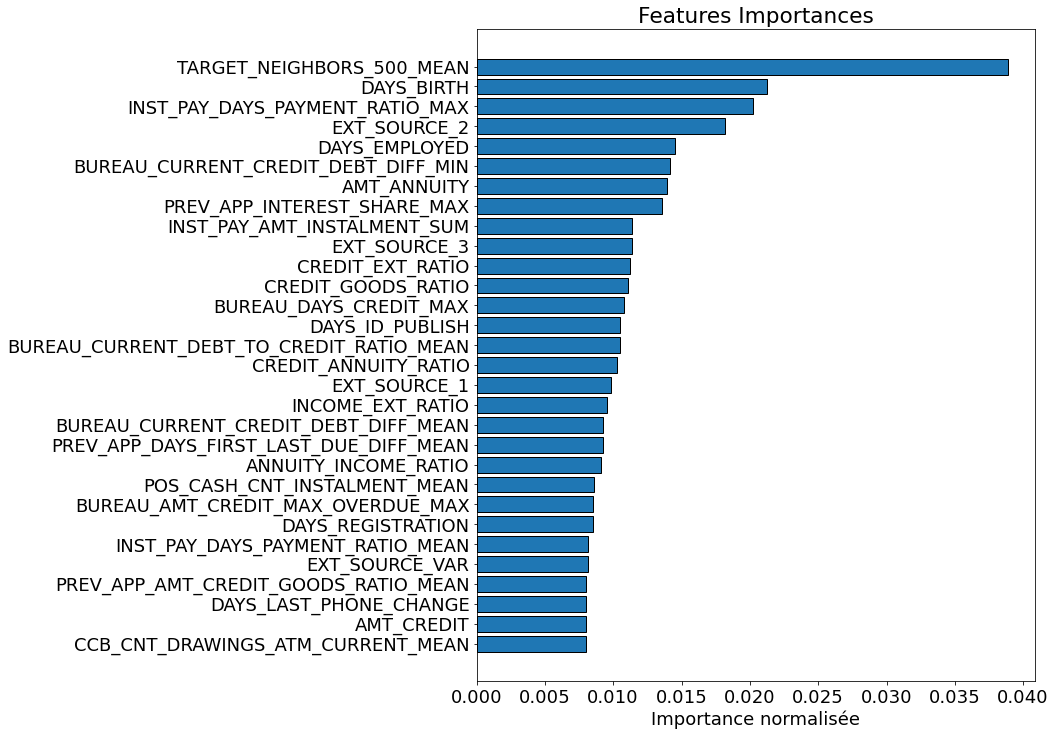

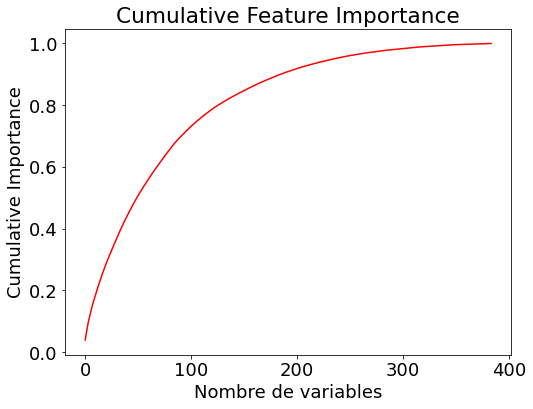

186 variables nécessaires pour 0.90 de cumulative importance


In [142]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_imp1_lightgbm_norm_3 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_imp1_lightgbm_3)

**Reconstitution des dataframes**

In [182]:
train_imp1_fs_lgbm['TARGET'] = train_imp1_fs_lgbm_labels
train_imp1_fs_lgbm['SK_ID_CURR'] = train_imp1_fs_lgbm_ids
print(f'train_imp1_fs_lgbm : {train_imp1_fs_lgbm.shape}')
test_imp1_fs_lgbm['SK_ID_CURR'] = test_imp1_fs_lgbm_ids
print(f'test_imp1_fs_lgbm : {test_imp1_fs_lgbm.shape}')

train_imp1_fs_lgbm : (307507, 386)
test_imp1_fs_lgbm : (48744, 385)


**Sauvegarde**

In [143]:
# Sauvegarde des features importances avec lightgbm
fic_sav_fs_imp1_lightgbm = \
    '../sauvegarde/features-selection/fs_imp1_lightgbm.pickle'
with open(fic_sav_fs_imp1_lightgbm, 'wb') as f:
    pickle.dump(df_fs_imp1_lightgbm_3, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [12]:
# Chargement des features importance de ligthgbm
fic_sav_fs_train_imp1_set = \
    '../sauvegarde/features-selection/fs_imp1_lightgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_train_imp1_set, 'rb') as df_fs_train_imp1_set:
    df_fs_imp1_lightgbm = pickle.load(df_fs_train_imp1_set)
df_fs_imp1_lightgbm.shape

(384, 2)

In [13]:
# Sauvegarde du nombre de features importance
df_fs_train_imp1_set = pd.DataFrame({})
df_fs_train_imp1_set = \
    outils_preprocessing.tracer_features_importance(df_fs_imp1_lightgbm,
                                                    df_fs_train_imp1_set,
                                                    'train_imp1_set',
                                                    'lightgbm')

train_imp1_set - lightgbm : 384 variables importantes conservées


<span style='background:Moccasin'>**Train_imp2_set/test_imp2_set**</span>

**Préparation des dataframes de travail**

In [147]:
# Résumé des variables qualitatives
desc_train_imp2_set = outils_data.description_variables(train_imp2_set)
desc_train_imp2_set

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BUILD_AVG,FLOORSMIN_AVG,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_EXT_RATIO,LAST_PHONE_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,EXT_SOURCE_SUM,EXT_SOURCE_MAX,EXT_SOURCE_VAR,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,TARGET_NEIGHBORS_500_MEAN,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_GROUP_OF_PEOPLE,NAME_TYPE_SUITE_OTHER_A,NAME_TYPE_SUITE_OTHER_B,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_TYPE_SUITE_UNACCOMPANIED,NAME_TYPE_SUITE_XNA,NAME_INCOME_TYPE_BUSINESSMAN,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_STUDENT,NAME_INCOME_TYPE_UNEMPLOYED,NAME_INCOME_TYPE_WORKING,NAME_INCOME_TYPE_XNA,NAME_EDUCATION_TYPE_ACADEMIC_DEGREE,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,NAME_EDUCATION_TYPE_INCOMPLETE_HIGHER,NAME_EDUCATION_TYPE_LOWER_SECONDARY,NAME_FAMILY_STATUS_CIVIL_MARRIAGE,NAME_FAMILY_STATUS_MARRIED,NAME_FAMILY_STATUS_SEPARATED,NAME_FAMILY_STATUS_SINGLE_NOT_MARRIED,NAME_FAMILY_STATUS_WIDOW,NAME_FAMILY_STATUS_XNA,NAME_HOUSING_TYPE_CO_OP_APARTMENT,NAME_HOUSING_TYPE_HOUSE_APARTMENT,NAME_HOUSING_TYPE_MUNICIPAL_APARTMENT,NAME_HOUSING_TYPE_OFFICE_APARTMENT,NAME_HOUSING_TYPE_RENTED_APARTMENT,NAME_HOUSING_TYPE_WITH_PARENTS,OCCUPATION_TYPE_ACCOUNTANTS,OCCUPATION_TYPE_CLEANING_STAFF,OCCUPATION_TYPE_COOKING_STAFF,OCCUPATION_TYPE_CORE_STAFF,OCCUPATION_TYPE_DRIVERS,OCCUPATION_TYPE_HR_STAFF,OCCUPATION_TYPE_HIGH_SKILL_TECH_STAFF,OCCUPATION_TYPE_IT_STAFF,OCCUPATION_TYPE_LABORERS,OCCUPATION_TYPE_LOW_SKILL_LABORERS,OCCUPATION_TYPE_MANAGERS,OCCUPATION_TYPE_MEDICINE_STAFF,OCCUPATION_TYPE_PRIVATE_SERVICE_STAFF,OCCUPATION_TYPE_REALTY_AGENTS,OCCUPATION_TYPE_SALES_STAFF,OCCUPATION_TYPE_SECRETARIES,OCCUPATION_TYPE_SECURITY_STAFF,OCCUPATION_TYPE_WAITERS_BARMEN_STAFF,OCCUPATION_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_ADVERTISING,ORGANIZATION_TYPE_AGRICULTURE,ORGANIZATION_TYPE_BANK,ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_1,ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_2,ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_3,ORGANIZATION_TYPE_CLEANING,ORGANIZATION_TYPE_CONSTRUCTION,ORGANIZATION_TYPE_CULTURE,ORGANIZATION_TYPE_ELECTRICITY,ORGANIZATION_TYPE_EMERGENCY,ORGANIZATION_TYPE_GOVERNMENT,ORGANIZATION_TYPE_HOTEL,ORGANIZATION_TYPE_HOUSING,ORGANIZATION_TYPE_INDUSTRY_TYPE_1,ORGANIZATION_TYPE_INDUSTRY_TYPE_10,ORGANIZATION_TYPE_INDUSTRY_TYPE_11,ORGANIZATION_TYPE_INDUSTRY_TYPE_12,ORGANIZATION_TYPE_INDUSTRY_TYPE_13,ORGANIZATION_TYPE_INDUSTRY_TYPE_2,ORGANIZATION_TYPE_INDUSTRY_TYPE_3,ORGANIZATION_TYPE_INDUSTRY_TYPE_4,ORGANIZATION_TYPE_INDUSTRY_TYPE_5,ORGANIZATION_TYPE_INDUSTRY_TYPE_6,ORGANIZA

In [21]:
# Dataframes de travail
train_imp2_fs_lgbm = train_imp2_set.copy()
print(f'train_fs_lgbm : {train_imp2_fs_lgbm.shape}')
test_imp2_fs_lgbm = test_imp2_set.copy()
print(f'test_fs_lgbm : {test_imp2_fs_lgbm.shape}')

train_fs_lgbm : (307507, 614)
test_fs_lgbm : (48744, 613)


In [22]:
# Sauvegarde des étiquettes car l'alignement supprimera
# cette variable.
train_imp2_fs_lgbm_labels = train_imp2_fs_lgbm['TARGET']

# Sauvegarde des identifiants
train_imp2_fs_lgbm_ids = train_imp2_fs_lgbm['SK_ID_CURR']
test_imp2_fs_lgbm_ids = test_imp2_fs_lgbm['SK_ID_CURR']

# Alignement des dataframes (suppression variable TARGET)
train_imp2_fs_lgbm, test_im2_fs_lgbm = \
    train_imp2_fs_lgbm.align(test_imp2_fs_lgbm, join='inner', axis=1)

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_imp2_fs_lgbm = train_imp2_fs_lgbm.drop(columns=['SK_ID_CURR'])
test_imp2_fs_lgbm = test_imp2_fs_lgbm.drop(columns=['SK_ID_CURR'])

print(f'train_imp2_fs_lgbm : {train_imp2_fs_lgbm.shape}')
print(f'test_imp2_fs_lgbm : {test_imp2_fs_lgbm.shape}')

train_imp2_fs_lgbm : (307507, 612)
test_imp2_fs_lgbm : (48744, 612)


**Modélisation**

***Premier passage***

In [23]:
# Initialiser un tableau vide pour contenir les features importance
feature_importances_imp2 = np.zeros(train_imp2_fs_lgbm.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=10000,
                           class_weight='balanced')

In [24]:
# Entraînement du modèle deux fois pour éviter l'overfitting
for i in range(2):

    # Split en jeux d'entraînement et de validation
    train_imp2_features, valid_imp2_features, train_imp2_y, valid_imp2_y = \
        train_test_split(train_imp2_fs_lgbm, train_imp2_fs_lgbm_labels,
                         test_size=0.25, random_state=i)

    # Entraînement en utilisant early stopping
    model.fit(train_imp2_features, train_imp2_y,
              early_stopping_rounds=100,
              eval_set=[(valid_imp2_features, valid_imp2_y)],
              eval_metric='auc', verbose=200)

    # Sauvegarde des features importances
    feature_importances_imp2 += model.feature_importances_

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.798696	valid_0's binary_logloss: 0.500977
Early stopping, best iteration is:
[197]	valid_0's auc: 0.798813	valid_0's binary_logloss: 0.501766
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.791987	valid_0's binary_logloss: 0.499929
Early stopping, best iteration is:
[142]	valid_0's auc: 0.79208	valid_0's binary_logloss: 0.513886


In [25]:
# Assurez-vous de faire la moyenne des features importance !
# puisque le modèle a été entraîné 2 fois
feature_importances_imp2 = feature_importances_imp2 / 2
df_fs_imp2_lightgbm = \
    pd.DataFrame({'feature': list(train_imp2_fs_lgbm.columns),
                  'importance': feature_importances_imp2}) \
    .sort_values('importance', ascending=False)

df_fs_imp2_lightgbm.head()

,feature,importance
81,TARGET_NEIGHBORS_500_MEAN,173.0
9,DAYS_BIRTH,93.5
255,INST_PAY_DAYS_PAYMENT_RATIO_MAX,89.0
74,EXT_SOURCE_SUM,77.5
27,EXT_SOURCE_2,71.5


In [26]:
# Exploration des variables avec zéro importance
# Find the features with zero importance
zero_features_imp2 = \
    list(df_fs_imp2_lightgbm[df_fs_imp2_lightgbm['importance'] == 0.0][
    'feature'])
print(f'{len(zero_features_imp2)} variables avec 0.0 importance :\n')
zero_features_imp2

179 variables avec 0.0 importance :



['FLAG_EMP_PHONE',
 'FLAG_DOCUMENT_12',
 'PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITHOUT_INTEREST_MEAN',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_3_SUM',
 'FLAG_CONT_MOBILE',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_2_SUM',
 'BUREAU_CREDIT_ACTIVE_BAD_DEBT_SUM',
 'BUREAU_CREDIT_TYPE_ANOTHER_TYPE_OF_LOAN_SUM',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_4_SUM',
 'BUREAU_FLAG_OVERDUE_RECENT_SUM',
 'REG_REGION_NOT_LIVE_REGION',
 'FLAG_EMAIL',
 'PREV_APP_PRODUCT_COMBINATION_POS_MOBILE_WITHOUT_INTEREST_SUM',
 'FLAG_MOBIL',
 'FLAG_DOCUMENT_11',
 'NAME_TYPE_SUITE_OTHER_B',
 'PREV_APP_PRODUCT_COMBINATION_POS_OTHERS_WITHOUT_INTEREST_MEAN',
 'NAME_EDUCATION_TYPE_LOWER_SECONDARY',
 'NAME_TYPE_SUITE_GROUP_OF_PEOPLE',
 'BUREAU_CREDIT_TYPE_UNKNOWN_TYPE_OF_LOAN_SUM',
 'NAME_INCOME_TYPE_XNA',
 'NAME_TYPE_SUITE_OTHER_A',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_BUSINESS_DEVELOPMENT_SUM',
 'NAME_INCOME_TYPE_UNEMPLOYED',
 'NAME_INCOME_TYPE_STUDENT',
 'BUREAU_CREDIT_TYPE_REAL_ESTATE_LOAN_MEAN',
 'NAME_INCOME_TYPE_BUSINESSMAN',
 'BUREAU_C

5:5: E122 8


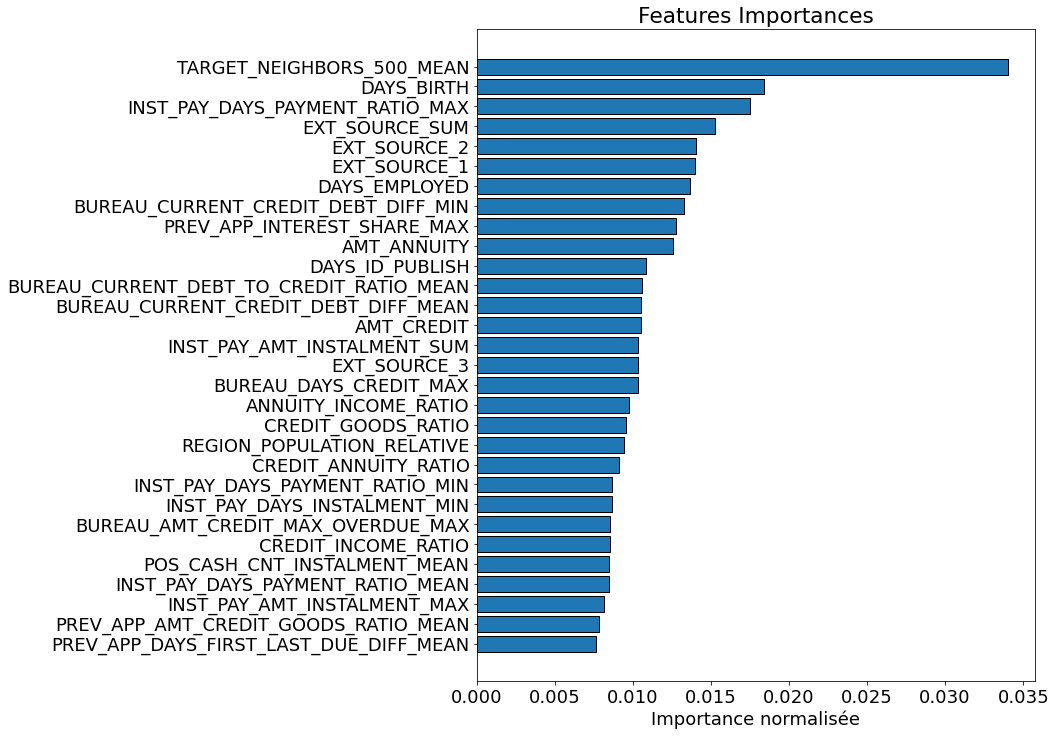

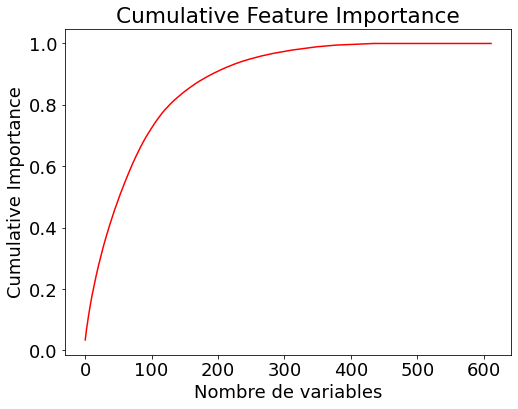

192 variables nécessaires pour 0.90 de cumulative importance


In [27]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_imp2_lightgbm_norm = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_imp2_lightgbm)

In [28]:
# Suppression des variables avec zéro importance
train_imp2_fs_lgbm = train_imp2_fs_lgbm.drop(columns=zero_features_imp2)
test_imp2_fs_lgbm = test_imp2_fs_lgbm.drop(columns=zero_features_imp2)

print(f'train_imp2_fs_lgbm : {train_imp2_fs_lgbm.shape}')
print(f'test_imp2_fs_lgbm : {test_imp2_fs_lgbm.shape}')

train_imp2_fs_lgbm : (307507, 433)
test_imp2_fs_lgbm : (48744, 433)


***Second passage***

In [29]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_imp2_2, df_fs_imp2_lightgbm_2 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_imp2_fs_lgbm,
                                       train_imp2_fs_lgbm_labels)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.796028	valid_0's binary_logloss: 0.501495
Early stopping, best iteration is:
[161]	valid_0's auc: 0.796333	valid_0's binary_logloss: 0.511245
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.791079	valid_0's binary_logloss: 0.500049
Early stopping, best iteration is:
[138]	valid_0's auc: 0.791782	valid_0's binary_logloss: 0.514901

There are 36 features with 0.0 importance


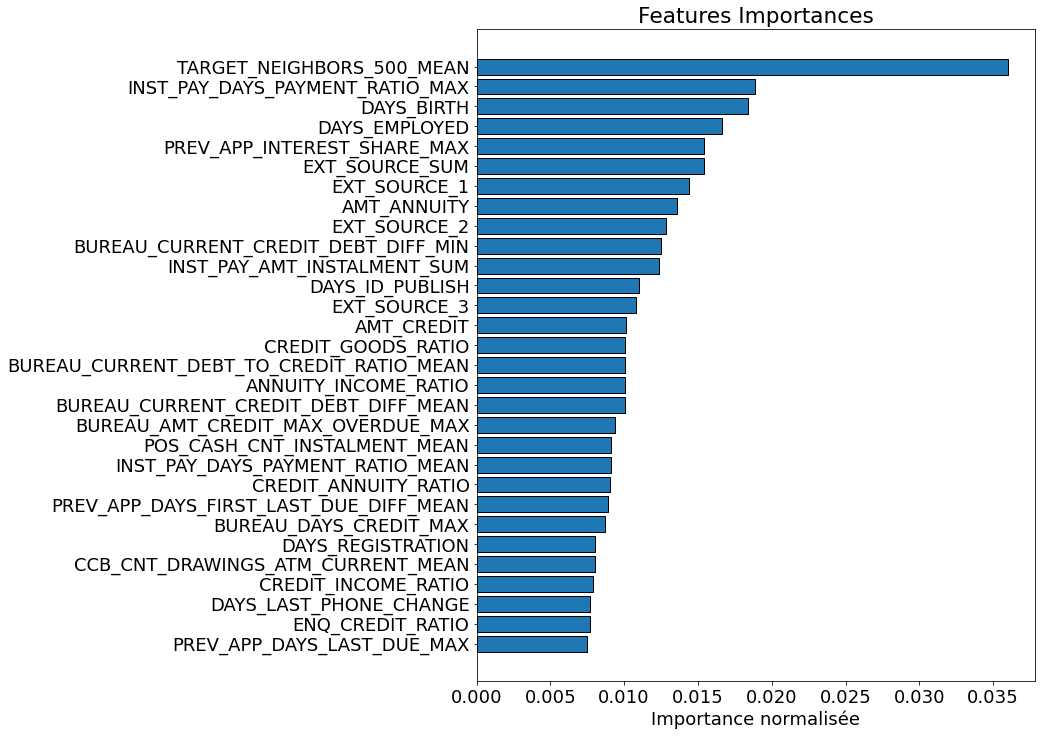

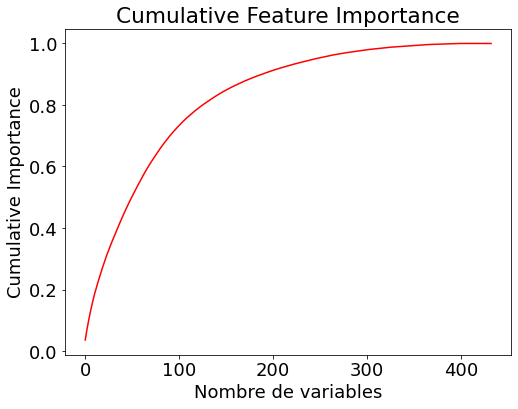

190 variables nécessaires pour 0.90 de cumulative importance


In [30]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_imp2_lightgbm_norm_2 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_imp2_lightgbm_2)

In [31]:
# Suppression des variables avec zéro importance
train_imp2_fs_lgbm = train_imp2_fs_lgbm.drop(columns=zero_features_imp2_2)
test_imp2_fs_lgbm = test_imp2_fs_lgbm.drop(columns=zero_features_imp2_2)

print(f'train_imp2_fs_lgbm : {train_imp2_fs_lgbm.shape}')
print(f'test_imp2_fs_lgbm : {test_imp2_fs_lgbm.shape}')

train_imp2_fs_lgbm : (307507, 397)
test_imp2_fs_lgbm : (48744, 397)


***Troisième passage***

In [32]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_imp2_3, df_fs_imp2_lightgbm_3 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_imp2_fs_lgbm,
                                       train_imp2_fs_lgbm_labels)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.795933	valid_0's binary_logloss: 0.501599
Early stopping, best iteration is:
[177]	valid_0's auc: 0.796333	valid_0's binary_logloss: 0.507473
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.79139	valid_0's binary_logloss: 0.499826
Early stopping, best iteration is:
[157]	valid_0's auc: 0.791808	valid_0's binary_logloss: 0.510139

There are 0 features with 0.0 importance


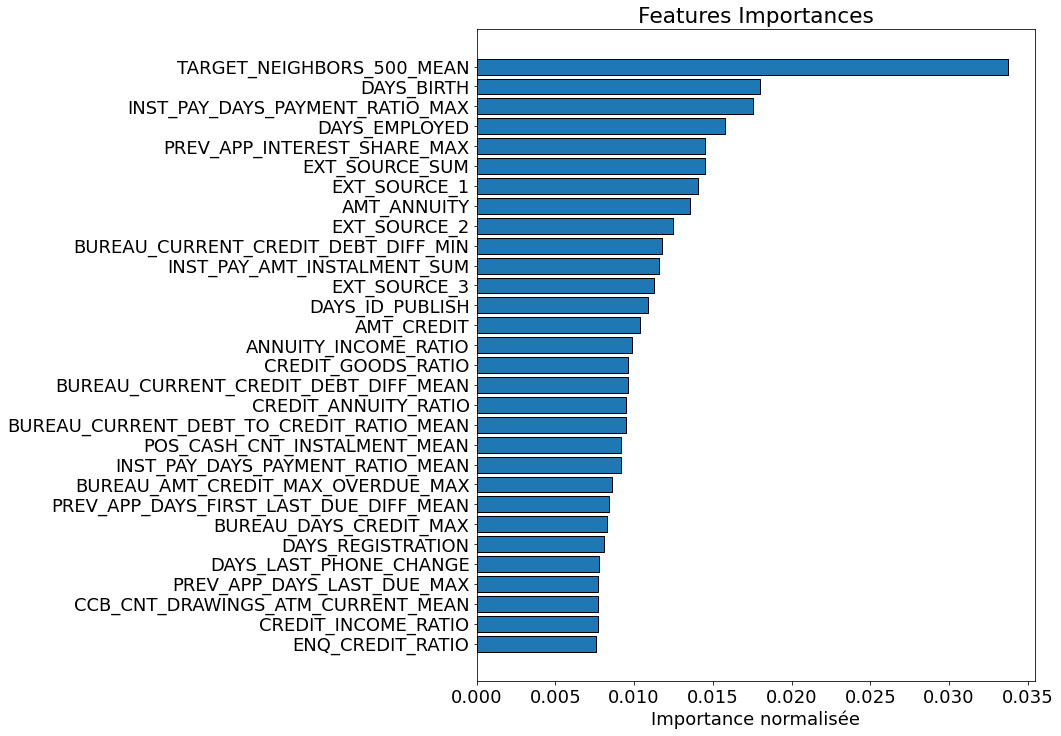

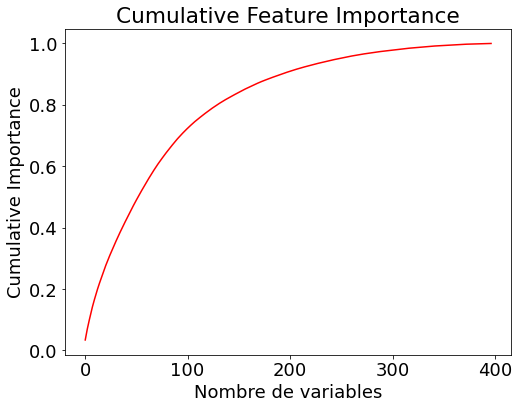

193 variables nécessaires pour 0.90 de cumulative importance


In [33]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_imp2_lightgbm_norm_3 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_imp2_lightgbm_3)

**Reconstitution des dataframes**

In [34]:
train_imp2_fs_lgbm['TARGET'] = train_imp2_fs_lgbm_labels
train_imp2_fs_lgbm['SK_ID_CURR'] = train_imp2_fs_lgbm_ids
print(f'train_imp2_fs_lgbm : {train_imp2_fs_lgbm.shape}')
test_imp2_fs_lgbm['SK_ID_CURR'] = test_imp2_fs_lgbm_ids
print(f'test_imp2_fs_lgbm : {test_imp2_fs_lgbm.shape}')

train_imp2_fs_lgbm : (307507, 399)
test_imp2_fs_lgbm : (48744, 398)


**Sauvegarde**

In [35]:
# Sauvegarde des features importances avec lightgbm
fic_sav_fs_imp2_lightgbm = \
    '../sauvegarde/features-selection/fs_imp2_lightgbm.pickle'
with open(fic_sav_fs_imp2_lightgbm, 'wb') as f:
    pickle.dump(df_fs_imp2_lightgbm_3, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [14]:
# Chargement des features importance de ligthgbm
fic_sav_fs_train_imp2_set = \
    '../sauvegarde/features-selection/fs_imp2_lightgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_train_imp2_set, 'rb') as df_fs_train_imp2_set:
    df_fs_imp2_lightgbm = pickle.load(df_fs_train_imp2_set)
df_fs_imp2_lightgbm.shape

(397, 2)

In [15]:
# Sauvegarde du nombre de features importance
df_fs_train_imp2_set = pd.DataFrame({})
df_fs_train_imp2_set = \
    outils_preprocessing.tracer_features_importance(df_fs_imp2_lightgbm,
                                                    df_fs_train_imp2_set,
                                                    'train_imp2_set',
                                                    'lightgbm')

train_imp2_set - lightgbm : 397 variables importantes conservées


### <span style='background:PowderBlue'>3.2. Features selection : avec BORUTA</span>

- Extrait du Kernel Kaggle de Robert Smith : [Source](https://www.kaggle.com/rsmits/feature-selection-with-boruta)

Boruta, comme RFE, est une technique de sélection de caractéristiques basée sur des enveloppes. Elle est moins connue mais tout aussi puissante. L'idée derrière Boruta est très simple. Étant donné un ensemble de données tabulaires, nous ajustons itérativement un algorithme supervisé (généralement un modèle basé sur un arbre) sur une version étendue des données. La version étendue, à chaque itération, est composée des données d'origine avec, attachée horizontalement, une copie des colonnes mélangées. Nous ne conservons que les caractéristiques qui, dans chaque itération :
ont une plus grande importance que la meilleure des caractéristiques mélangées ;
sont meilleures que prévu par rapport au hasard (en utilisant une distribution binomiale).

- Boruta : [Source](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a) [Source](https://towardsdatascience.com/boruta-and-shap-for-better-feature-selection-20ea97595f4a) [Source](https://blog.exploratory.io/finding-variable-importance-with-random-forest-boruta-28badd116197) [Source](https://towardsdatascience.com/simple-example-using-boruta-feature-selection-in-python-8b96925d5d7a)

<span style='background:Moccasin'>**Train_set/test_set**</span>

***Avec model RandomForestClassifier***

**Préparation du dataframe de travail**

In [42]:
# Dataframes de travail
train_fs_boruta = train_set.copy()
print(f'train_fs_boruta : {train_fs_boruta.shape}')

train_fs_boruta : (307507, 615)
test_fs_boruta : (48744, 614)


In [43]:
# Sauvegarde des étiquettes
train_fs_boruta_labels = train_fs_boruta['TARGET']

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_fs_boruta = train_fs_boruta.drop(columns=['SK_ID_CURR'])
train_fs_boruta = train_fs_boruta.drop(columns=['TARGET'])

print(f'train_fs_boruta : {train_fs_boruta.shape}')

train_fs_boruta : (307507, 613)
test_fs_boruta : (48744, 613)


In [48]:
# Initialisation des variables
X = train_fs_boruta.values
y = train_fs_boruta_labels.values.ravel()

- Ensuite, nous configurons le RandomForestClassifier comme estimateur
à utiliser pour Boruta.
- Le max_depth de l'arbre est conseillé sur la page Github de Boruta pour
être entre 3 et 7.

In [54]:
rf = RandomForestClassifier(n_jobs=-1,
                            class_weight='balanced',
                            max_depth=5)

- Ensuite, nous configurons Boruta.
    - Il utilise l'interface scikit-learn autant que possible, donc nous pouvons utiliser fit(X, y), transform(X), fit_transform(X, y).
    - Je le laisse tourner pour un maximum de max_iter = 50 itérations.
    - Avec perc = 90, un seuil est spécifié.
    - Plus le seuil est bas, plus de caractéristiques seront sélectionnées.
    - J'utilise généralement un pourcentage entre 80 et 90.

In [57]:
# Initialisation de Boruta
boruta_feature_selector = BorutaPy(rf,
                                   n_estimators='auto',
                                   verbose=2,
                                   random_state=21,
                                   max_iter=50,
                                   perc=90)
# Entraînement
boruta_feature_selector.fit(X, y)

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	227
Tentative: 	75
Rejected: 	311
Iteration: 	9 / 50
Confirmed: 	227
Tentative: 	75
Rejected: 	311
Iteration: 	10 / 50
Confirmed: 	227
Tentative: 	75
Rejected: 	311
Iteration: 	11 / 50
Confirmed: 	227
Tentative: 	75
Rejected: 	311
Iteration: 	12 / 50
Confirmed: 	228
Tentative: 	74
Rejected: 	311
Iteration: 	13 / 50
Confirmed: 	228
Tentative: 	58
Rejected: 	327
Iteration: 	14 / 50
Confirmed: 	228
Tentative: 	58
Rejected: 	327
Iteration: 	15 / 50
Confirmed: 	228
Tentative: 	58
Rejected: 	327
Iteration: 	16 / 50
Confirmed: 	229
Tent

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=448, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x212EC877940),
         max_iter=50, n_estimators='auto', perc=90,
         random_state=RandomState(MT19937) at 0x212EC877940, verbose=2)

In [58]:
# On applique le modèle sur le dataset
X_filtered = boruta_feature_selector.transform(X)
X_filtered.shape

(307507, 229)

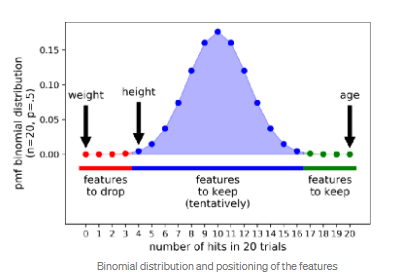

In [75]:
# Liste des variables confirmées avec une haute importance
%pycodestyle_off
fs_boruta = list()
features = [f for f in train_fs_boruta.columns]
indexes = np.where(boruta_feature_selector.support_ == True)
for x in np.nditer(indexes):
    fs_boruta.append(features[x])
display(f'fs_boruta : {fs_boruta}')
%pycodestyle_on

"fs_boruta : ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'NONLIVINGAREA_AVG', 'EMERGENCYSTATE_MODE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'CREDIT_INCOME_RATIO', 'CREDIT_ANNUITY_RATIO', 'ANNUITY_INCOME_RATIO', 'CREDIT_GOODS_RATIO', 'INCOME_GOODS_DIFF', 'INCOME_EXT_RATIO', 'LAST_PHONE_EMPLOYED_RATIO', 'CAR_EMPLOYED_RATIO', 'FLAG_CONTACTS_SUM', 'EXT_SOURCE_SUM', 'EXT_SOURCE_MAX', 'EXT_SOURCE_VAR', 'OBS_DEF_30_MUL', 'OBS_30_CRE

In [76]:
# Dataframe de features importance avec boruta
df_fs_boruta = pd.DataFrame(fs_boruta)

**Sauvegarde**

In [77]:
# Sauvegarde des features importances avec boruta
fic_sav_fs_boruta = \
    '../sauvegarde/features-selection/fs_boruta.pickle'
with open(fic_sav_fs_boruta, 'wb') as f:
    pickle.dump(df_fs_boruta, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [16]:
# Chargement des features importance de boruta
fic_sav_fs_boruta = \
    '../sauvegarde/features-selection/fs_boruta.pickle'
# Chargement des features importance
with open(fic_sav_fs_boruta, 'rb') as df_fs_boruta:
    df_fs_boruta = pickle.load(df_fs_boruta)
df_fs_boruta.shape

(229, 1)

In [17]:
# Sauvegarde du nombre de features importance
df_fs_train_set = \
    outils_preprocessing.tracer_features_importance(df_fs_boruta,
                                                    df_fs_train_set,
                                                    'train_set',
                                                    'boruta-RandomForest')

train_set - boruta-RandomForest : 229 variables importantes conservées


***Avec model Lightgbm***

- En utilisant une classe spécifique suite à l'erreur 'num_boost_round' ne peut pas être nulle.

**Préparation du dataframe de travail**

In [35]:
# Dataframes de travail
train_fs_boruta_lgbm = train_set.copy()
print(f'train_fs_boruta_lgbm : {train_fs_boruta_lgbm.shape}')

train_fs_boruta_lgbm : (307507, 615)


In [36]:
# Sauvegarde des étiquettes
train_fs_boruta_lgbm_labels = train_fs_boruta_lgbm['TARGET']

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_fs_boruta_lgbm = train_fs_boruta_lgbm.drop(columns=['SK_ID_CURR'])
train_fs_boruta_lgbm = train_fs_boruta_lgbm.drop(columns=['TARGET'])

print(f'train_fs_boruta_lgbm : {train_fs_boruta_lgbm.shape}')

train_fs_boruta_lgbm : (307507, 613)


In [37]:
# Initialisation des variables
X = train_fs_boruta_lgbm.values
y = train_fs_boruta_lgbm_labels.values.ravel()

In [46]:
# Create the model with several hyperparameters
lgbm = lgb.LGBMClassifier(objective='binary',
                          boosting_type='goss',
                          n_estimators=10000,
                          class_weight='balanced',
                          num_boost_round=100)

- Ensuite, nous configurons Boruta.
    - Il utilise l'interface scikit-learn autant que possible, donc nous pouvons utiliser fit(X, y), transform(X), fit_transform(X, y).
    - Je le laisse tourner pour un maximum de max_iter = 50 itérations.
    - Avec perc = 90, un seuil est spécifié.
    - Plus le seuil est bas, plus de caractéristiques seront sélectionnées.
    - J'utilise généralement un pourcentage entre 80 et 90.

In [47]:
# Initialisation de Boruta
boruta_feature_selector_lgbm = \
    outils_preprocessing.BorutaPyForLGB(lgbm,
                                        n_estimators='auto',
                                        verbose=2,
                                        random_state=21,
                                        max_iter=50,
                                        perc=90)
# Entraînement
boruta_feature_selector_lgbm.fit(X, y)

BorutaPyForLGB(estimator=LGBMClassifier(boosting_type='goss',
                                        class_weight='balanced',
                                        n_estimators=-1593, num_boost_round=100,
                                        objective='binary', random_state=9214),
               max_iter=50, n_estimators='auto', perc=90,
               random_state=RandomState(MT19937) at 0x1BBDB31DA40, verbose=2)

In [48]:
# On applique le modèle sur le dataset
X_filtered_lgbm = boruta_feature_selector_lgbm.transform(X)
X_filtered_lgbm.shape

(307507, 110)

In [49]:
# Liste des variables confirmées avec une haute importance
%pycodestyle_off
fs_boruta_lgbm = list()
features_lgbm = [f for f in train_fs_boruta_lgbm.columns]
indexes_lgbm = np.where(boruta_feature_selector_lgbm.support_ == True)
for x in np.nditer(indexes_lgbm):
    fs_boruta_lgbm.append(features_lgbm[x])
display(f'fs_boruta_lgbm : {fs_boruta_lgbm}')
%pycodestyle_on

"fs_boruta_lgbm : ['CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'REGION_RATING_CLIENT', 'REG_CITY_NOT_LIVE_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'CREDIT_INCOME_RATIO', 'CREDIT_ANNUITY_RATIO', 'ANNUITY_INCOME_RATIO', 'CREDIT_GOODS_RATIO', 'INCOME_GOODS_DIFF', 'INCOME_EXT_RATIO', 'CAR_EMPLOYED_RATIO', 'EXT_SOURCE_SUM', 'EXT_SOURCE_MAX', 'EXT_SOURCE_VAR', 'ENQ_CREDIT_RATIO', 'TARGET_NEIGHBORS_500_MEAN', 'NAME_INCOME_TYPE_WORKING', 'NAME_EDUCATION_TYPE_HIGHER_EDUCATION', 'NAME_FAMILY_STATUS_MARRIED', 'OCCUPATION_TYPE_CORE_STAFF', 'ORGANIZATION_TYPE_SELF_EMPLOYED', 'CCB_NAME_CONTRACT_STATUS_ACTIVE_SUM', 'CCB_AMT_BALANCE_MEAN', 'CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'CCB_CNT_DRAWINGS_CURRENT_SUM', 'CCB_BALANCE_L

In [50]:
# Dataframe de features importance avec boruta
df_fs_boruta_lgbm = pd.DataFrame(fs_boruta_lgbm)

**Sauvegarde**

In [51]:
# Sauvegarde des features importances avec boruta
fic_sav_fs_boruta_lgbm = \
    '../sauvegarde/features-selection/fs_boruta_lgbm.pickle'
with open(fic_sav_fs_boruta_lgbm, 'wb') as f:
    pickle.dump(df_fs_boruta_lgbm, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [18]:
# Chargement des features importance de boruta
fic_sav_fs_boruta_lgbm = \
    '../sauvegarde/features-selection/fs_boruta_lgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_boruta_lgbm, 'rb') as df_fs_boruta_lgbm:
    df_fs_boruta_lgbm = pickle.load(df_fs_boruta_lgbm)
df_fs_boruta_lgbm.shape

(110, 1)

In [19]:
# Sauvegarde du nombre de features importance
df_fs_train_set = \
    outils_preprocessing.tracer_features_importance(df_fs_boruta_lgbm,
                                                    df_fs_train_set,
                                                    'train_set',
                                                    'boruta-LightGbm-1')

train_set - boruta-LightGbm-1 : 110 variables importantes conservées


***Avec model Lightgbm***

- En utilisant la classe non spécifique BorutaPy, en ajoutant 'num_boost_round' au modèle LightGbm, un warning est affiché mais plus l'erreur fatale.

**Préparation du dataframe de travail**

In [20]:
# Dataframes de travail
train_fs_boruta_lgbm2 = train_set.copy()
print(f'train_fs_boruta_lgbm2 : {train_fs_boruta_lgbm2.shape}')

train_fs_boruta_lgbm2 : (307507, 615)


In [21]:
# Sauvegarde des étiquettes
train_fs_boruta_lgbm2_labels = train_fs_boruta_lgbm2['TARGET']

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_fs_boruta_lgbm2 = train_fs_boruta_lgbm2.drop(columns=['SK_ID_CURR'])
train_fs_boruta_lgbm2 = train_fs_boruta_lgbm2.drop(columns=['TARGET'])

print(f'train_fs_boruta_lgbm2 : {train_fs_boruta_lgbm2.shape}')

train_fs_boruta_lgbm2 : (307507, 613)


In [22]:
# Initialisation des variables
X = train_fs_boruta_lgbm2.values
y = train_fs_boruta_lgbm2_labels.values.ravel()

In [25]:
# Create the model with several hyperparameters
lgbm2 = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=10000,
                           class_weight='balanced',
                           num_boost_round=100)

- Ensuite, nous configurons Boruta.
    - Il utilise l'interface scikit-learn autant que possible, donc nous pouvons utiliser fit(X, y), transform(X), fit_transform(X, y).
    - Je le laisse tourner pour un maximum de max_iter = 50 itérations.
    - Avec perc = 90, un seuil est spécifié.
    - Plus le seuil est bas, plus de caractéristiques seront sélectionnées.
    - J'utilise généralement un pourcentage entre 80 et 90.

In [26]:
# Initialisation de Boruta
boruta_feature_selector_lgbm2 = BorutaPy(lgbm2,
                                         n_estimators='auto',
                                         verbose=2,
                                         random_state=21,
                                         max_iter=50,
                                         perc=90)
# Entraînement
boruta_feature_selector_lgbm2.fit(X, y)

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	105
Tentative: 	94
Rejected: 	414
Iteration: 	9 / 50
Confirmed: 	105
Tentative: 	94
Rejected: 	414
Iteration: 	10 / 50
Confirmed: 	105
Tentative: 	94
Rejected: 	414
Iteration: 	11 / 50
Confirmed: 	105
Tentative: 	94
Rejected: 	414
Iteration: 	12 / 50
Confirmed: 	106
Tentative: 	72
Rejected: 	435
Iteration: 	13 / 50
Confirmed: 	106
Tentative: 	72
Rejected: 	435
Iteration: 	14 / 50
Confirmed: 	106
Tentative: 	72
Re

BorutaPy(estimator=LGBMClassifier(boosting_type='goss', class_weight='balanced',
                                  n_estimators=-1562, num_boost_round=100,
                                  objective='binary',
                                  random_state=RandomState(MT19937) at 0x1DE79CF7E40),
         max_iter=50, n_estimators='auto', perc=90,
         random_state=RandomState(MT19937) at 0x1DE79CF7E40, verbose=2)

In [27]:
# On applique le modèle sur le dataset
X_filtered_lgbm2 = boruta_feature_selector_lgbm2.transform(X)
X_filtered_lgbm2.shape

(307507, 107)

In [28]:
# Liste des variables confirmées avec une haute importance
%pycodestyle_off
fs_boruta_lgbm2 = list()
features_lgbm2 = [f for f in train_fs_boruta_lgbm2.columns]
indexes_lgbm2 = np.where(boruta_feature_selector_lgbm2.support_ == True)
for x in np.nditer(indexes_lgbm2):
    fs_boruta_lgbm2.append(features_lgbm2[x])
display(f'fs_boruta_lgbm : {fs_boruta_lgbm2}')
%pycodestyle_on

"fs_boruta_lgbm : ['CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'REGION_RATING_CLIENT', 'REG_CITY_NOT_LIVE_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'CREDIT_INCOME_RATIO', 'CREDIT_ANNUITY_RATIO', 'ANNUITY_INCOME_RATIO', 'CREDIT_GOODS_RATIO', 'INCOME_GOODS_DIFF', 'INCOME_EXT_RATIO', 'CAR_EMPLOYED_RATIO', 'EXT_SOURCE_SUM', 'EXT_SOURCE_MAX', 'EXT_SOURCE_VAR', 'ENQ_CREDIT_RATIO', 'TARGET_NEIGHBORS_500_MEAN', 'NAME_INCOME_TYPE_WORKING', 'NAME_EDUCATION_TYPE_HIGHER_EDUCATION', 'NAME_FAMILY_STATUS_MARRIED', 'OCCUPATION_TYPE_CORE_STAFF', 'ORGANIZATION_TYPE_SELF_EMPLOYED', 'CCB_NAME_CONTRACT_STATUS_ACTIVE_SUM', 'CCB_AMT_BALANCE_MEAN', 'CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'CCB_CNT_DRAWINGS_CURRENT_SUM', 'CCB_BALANCE_L

In [29]:
# Dataframe de features importance avec boruta
df_fs_boruta_lgbm2 = pd.DataFrame(fs_boruta_lgbm2)

**Sauvegarde**

In [30]:
# Sauvegarde des features importances avec boruta
fic_sav_fs_boruta_lgbm2 = \
    '../sauvegarde/features-selection/fs_boruta_lgbm2.pickle'
with open(fic_sav_fs_boruta_lgbm2, 'wb') as f:
    pickle.dump(df_fs_boruta_lgbm2, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [20]:
# Chargement des features importance de boruta
fic_sav_fs_boruta_lgbm2 = \
    '../sauvegarde/features-selection/fs_boruta_lgbm2.pickle'
# Chargement des features importance
with open(fic_sav_fs_boruta_lgbm2, 'rb') as df_fs_boruta_lgbm2:
    df_fs_boruta_lgbm2 = pickle.load(df_fs_boruta_lgbm2)
df_fs_boruta_lgbm2.shape

(107, 1)

In [21]:
# Sauvegarde du nombre de features importance
df_fs_train_set = \
    outils_preprocessing.tracer_features_importance(df_fs_boruta_lgbm2,
                                                    df_fs_train_set,
                                                    'train_set',
                                                    'boruta-LightGbm-2')

train_set - boruta-LightGbm-2 : 107 variables importantes conservées


<span style='background:Moccasin'>**Train_imp1_set/test_imp1_set**</span>

***Avec RandomForest***

**Préparation du dataframe de travail**

In [20]:
# Dataframes de travail
train_imp1_fs_boruta = train_imp1_set.copy()
print(f'train_imp1_fs_boruta : {train_imp1_fs_boruta.shape}')

train_imp1_fs_boruta : (307507, 622)


In [25]:
# Gestion des valeurs infinies
train_imp1_fs_boruta = train_imp1_fs_boruta.replace([np.inf, -np.inf],
                                                    np.nan)
train_imp1_fs_boruta = train_imp1_fs_boruta.fillna(0)

**Feature sélection avec boruta**

In [26]:
df_fs_imp1_boruta =\
    outils_preprocessing.features_selection_boruta(train_imp1_fs_boruta,
                                                   'fs_imp1_boruta')

train_fs_boruta : (307507, 620)
Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	620
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	620
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	620
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	620
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	620
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	620
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	620
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	238
Tentative: 	68
Rejected: 	314
Iteration: 	9 / 50
Confirmed: 	238
Tentative: 	68
Rejected: 	314
Iteration: 	10 / 50
Confirmed: 	238
Tentative: 	68
Rejected: 	314
Iteration: 	11 / 50
Confirmed: 	238
Tentative: 	68
Rejected: 	314
Iteration: 	12 / 50
Confirmed: 	240
Tentative: 	66
Rejected: 	314
Iteration: 	13 / 50
Confirmed: 	240
Tentative: 	66
Rejected: 	314
Iteration: 	14 / 50
Confirmed: 	240
Tentative: 	57
Rejected: 	323
Iteration: 	15 / 50
Confirmed: 	240
Tentative: 	57
Rejected: 	323
Iteratio

**Chargement du dataframe sauvegardé**

In [22]:
# Chargement des features importance de boruta
fic_sav_fs_imp1_boruta = \
    '../sauvegarde/features-selection/fs_imp1_boruta.pickle'
# Chargement des features importance
with open(fic_sav_fs_imp1_boruta, 'rb') as df_fs_imp1_boruta:
    df_fs_imp1_boruta = pickle.load(df_fs_imp1_boruta)
df_fs_imp1_boruta.shape

(240, 1)

In [23]:
# Sauvegarde du nombre de features importance
df_fs_train_imp1_set = \
    outils_preprocessing.tracer_features_importance(df_fs_imp1_boruta,
                                                    df_fs_train_imp1_set,
                                                    'train_imp1_set',
                                                    'boruta-RandomForest')

train_imp1_set - boruta-RandomForest : 240 variables importantes conservées


***Avec Lightgbm***

**Préparation du dataframe de travail**

In [21]:
# Dataframes de travail
train_imp1_fs_boruta_lgbm = train_imp1_set.copy()
print(f'train_imp1_fs_boruta_lgbm : {train_imp1_fs_boruta_lgbm.shape}')

train_imp1_fs_boruta_lgbm : (307507, 622)


In [23]:
# Gestion des valeurs infinies
train_imp1_fs_boruta_lgbm = \
    train_imp1_fs_boruta_lgbm.replace([np.inf, -np.inf], np.nan)
train_imp1_fs_boruta_lgbm = train_imp1_fs_boruta_lgbm.fillna(0)

**Feature sélection avec boruta**

In [24]:
df_fs_imp1_boruta_lgbm = outils_preprocessing \
    .features_selection_boruta_lgbm(train_imp1_fs_boruta_lgbm,
                                    'fs_imp1_boruta_lgbm')

train_fs_boruta : (307507, 620)
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	620
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	620
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	620
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	620
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	620
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	620
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	620
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	103
Tentative: 	87
Rejected: 	430
Iteration: 	9 / 50
Confirmed: 	103
Tentative: 	87
Rejected: 	430
Iteration: 	10 / 50
Confirmed: 	103
Tentative: 	87
Rejected: 	430
Iteration: 	11 / 50
Confirmed: 	103
Tentative: 	87
Rejected: 	430
Iteration: 	12 / 50
Confirmed: 	104
Tentative: 	67
Rejected: 	449
Iteration: 	13 / 50
Confirmed: 	104
Tentative: 	67
Rejected: 	449
Iteration: 	14 / 50
C

**Chargement du dataframe sauvegardé**

In [24]:
# Chargement des features importance de boruta
fic_sav_fs_imp1_boruta_lgbm = \
    '../sauvegarde/features-selection/fs_imp1_boruta_lgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_imp1_boruta_lgbm, 'rb') as df_fs_imp1_boruta_lgbm:
    df_fs_imp1_boruta_lgbm = pickle.load(df_fs_imp1_boruta_lgbm)
df_fs_imp1_boruta_lgbm.shape

(107, 1)

In [25]:
# Sauvegarde du nombre de features importance
df_fs_train_imp1_set = \
    outils_preprocessing.tracer_features_importance(df_fs_imp1_boruta_lgbm,
                                                    df_fs_train_imp1_set,
                                                    'train_imp1_set',
                                                    'boruta-LightGbm')

train_imp1_set - boruta-LightGbm : 107 variables importantes conservées


<span style='background:Moccasin'>**Train_imp2_set/test_imp2_set**</span>

***Avec RandomForest***

**Préparation du dataframe de travail**

In [29]:
# Dataframes de travail
train_imp2_fs_boruta = train_set.copy()
print(f'train_imp2_fs_boruta : {train_imp2_fs_boruta.shape}')

train_imp2_fs_boruta : (307507, 615)


**Feature sélection avec boruta**

In [31]:
df_fs_imp2_boruta =\
    outils_preprocessing.features_selection_boruta(train_imp2_fs_boruta,
                                                   'fs_imp2_boruta')

train_fs_boruta : (307507, 613)
Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	613
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	227
Tentative: 	75
Rejected: 	311
Iteration: 	9 / 50
Confirmed: 	227
Tentative: 	75
Rejected: 	311
Iteration: 	10 / 50
Confirmed: 	227
Tentative: 	75
Rejected: 	311
Iteration: 	11 / 50
Confirmed: 	227
Tentative: 	75
Rejected: 	311
Iteration: 	12 / 50
Confirmed: 	228
Tentative: 	74
Rejected: 	311
Iteration: 	13 / 50
Confirmed: 	228
Tentative: 	58
Rejected: 	327
Iteration: 	14 / 50
Confirmed: 	228
Tentative: 	58
Rejected: 	327
Iteration: 	15 / 50
Confirmed: 	228
Tentative: 	58
Rejected: 	327
Iteratio

**Chargement du dataframe sauvegardé**

In [26]:
# Chargement des features importance de boruta
fic_sav_fs_imp2_boruta = \
    '../sauvegarde/features-selection/fs_imp2_boruta.pickle'
# Chargement des features importance
with open(fic_sav_fs_imp2_boruta, 'rb') as df_fs_imp2_boruta:
    df_fs_imp2_boruta = pickle.load(df_fs_imp2_boruta)
df_fs_imp2_boruta.shape

(229, 1)

In [27]:
# Sauvegarde du nombre de features importance
df_fs_train_imp2_set = \
    outils_preprocessing.tracer_features_importance(df_fs_imp2_boruta,
                                                    df_fs_train_imp2_set,
                                                    'train_imp2_set',
                                                    'boruta-RandomForest')

train_imp2_set - boruta-RandomForest : 229 variables importantes conservées


***Avec Lightgbm***

**Préparation du dataframe de travail**

In [47]:
# Dataframes de travail
train_imp2_fs_boruta_lgbm = train_imp2_set.copy()
print(f'train_imp2_fs_boruta_lgbm : {train_imp2_fs_boruta_lgbm.shape}')

train_imp2_fs_boruta_lgbm : (307507, 614)


**Feature sélection avec boruta**

In [48]:
df_fs_imp2_boruta_lgbm = outils_preprocessing \
    .features_selection_boruta_lgbm(train_imp2_fs_boruta_lgbm,
                                    'fs_imp2_boruta_lgbm')

train_fs_boruta : (307507, 612)
Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	612
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	612
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	612
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	612
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	612
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	612
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	612
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	93
Tentative: 	88
Rejected: 	431
Iteration: 	9 / 50
Confirmed: 	93
Tentative: 	88
Rejected: 	431
Iteration: 	10 / 50
Confirmed: 	93
Tentative: 	88
Rejected: 	431
Iteration: 	11 / 50
Confirmed: 	93
Tentative: 	88
Rejected: 	431
Iteration: 	12 / 50
Confirmed: 	93
Tentative: 	66
Rejected: 	453
Iteration: 	13 / 50
Confirmed: 	93
Tentative: 	66
Rejected: 	453
Iteration: 	14 / 50
Confirmed: 	93
Tentative: 	66
Rejected: 	453
Iteration: 	15 / 50
Confirmed: 	93
Tentative: 	66
Rejected: 	453
Iteration: 	16 /

**Chargement du dataframe sauvegardé**

In [28]:
# Chargement des features importance de boruta
fic_sav_fs_imp2_boruta_lgbm = \
    '../sauvegarde/features-selection/fs_imp2_boruta_lgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_imp2_boruta_lgbm, 'rb') as df_fs_imp2_boruta_lgbm:
    df_fs_imp2_boruta_lgbm = pickle.load(df_fs_imp2_boruta_lgbm)
df_fs_imp2_boruta_lgbm.shape

(95, 1)

In [29]:
# Sauvegarde du nombre de features importance
df_fs_train_imp2_set = \
    outils_preprocessing.tracer_features_importance(df_fs_imp2_boruta_lgbm,
                                                    df_fs_train_imp2_set,
                                                    'train_imp2_set',
                                                    'boruta-LightGbm')

train_imp2_set - boruta-LightGbm : 95 variables importantes conservées


### <span style='background:PowderBlue'>3.3. Features selection : avec BORUTASHAP</span>

- Librairie : [Source](https://pypi.org/project/BorutaShap/)
- La librairie BorutaShap, comme son nom l'indique, combine l'algorithme de sélection de caractéristiques Boruta avec la technique SHAP (SHapley Additive exPlanations).
- L'algorithme Boruta (du nom d'un dieu de la forêt dans la mythologie slave) a pour tâche de trouver un ensemble de caractéristiques optimal minimal plutôt que de trouver toutes les caractéristiques pertinentes pour la variable cible. 
- Cela conduit à une sélection non biaisée et stable des attributs importants et non importants. 
- La librairie BorutaShap a été écrit par Eoghan Keany, qui a également écrit un article d'introduction "Is this the Best Feature Selection Algorithm 'BorutaShap' ?" fournissant une vue d'ensemble du fonctionnement de BorutaShap : [Source](https://medium.com/analytics-vidhya/is-this-the-best-feature-selection-algorithm-borutashap-8bc238aa1677) - [Source](https://github.com/Ekeany/Boruta-Shap).

<span style='background:Moccasin'>**Train_set/test_set**</span>

**Préparation du dataframe de travail**

In [35]:
# Dataframes de travail
train_fs_borshap_lgbm = train_set.copy()
print(f'train_fs_borshap_lgbm : {train_fs_borshap_lgbm.shape}')

train_fs_borshap_lgbm : (307507, 615)


In [36]:
# Sauvegarde des étiquettes
train_fs_borshap_lgbm_labels = train_fs_borshap_lgbm['TARGET']

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_fs_borshap_lgbm = train_fs_borshap_lgbm.drop(columns=['SK_ID_CURR'])
train_fs_borshap_lgbm = train_fs_borshap_lgbm.drop(columns=['TARGET'])

print(f'train_fs_borshap_lgbm : {train_fs_borshap_lgbm.shape}')

train_fs_borshap_lgbm : (307507, 613)


In [37]:
# Initialisation des variables
X = train_fs_borshap_lgbm
y = train_fs_borshap_lgbm_labels

In [38]:
# Create the model with several hyperparameters
lgbm = lgb.LGBMClassifier(objective='binary',
                          boosting_type='goss',
                          n_estimators=10000,
                          class_weight='balanced',
                          num_boost_round=100)

In [39]:
# Initialisation de BorutaShap
Feature_Selector = BorutaShap(model=lgbm,
                              importance_measure='shap',
                              classification=True)

# Entraînement
Feature_Selector.fit(X=X, y=y, n_trials=100, random_state=0)

  0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, 

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, 

In [58]:
# Liste des variables avec une haute importance
fs_borshap_lgbm = Feature_Selector.accepted
fs_borshap_lgbm

['CAR_EMPLOYED_RATIO',
 'BUREAU_DAYS_CREDIT_MEAN',
 'EXT_SOURCE_3',
 'PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MIN_MEAN',
 'PREV_APP_INTEREST_SHARE_MAX',
 'INST_PAY_DAYS_PAYMENT_RATIO_MEAN',
 'INST_PAY_AMT_INSTALMENT_MIN',
 'AMT_ANNUITY',
 'INST_PAY_DAYS_PAYMENT_DIFF_MIN',
 'BUREAU_AMT_CREDIT_SUM_MEAN',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_ID_PUBLISH',
 'ENQ_CREDIT_RATIO',
 'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
 'INST_PAY_AMT_INSTALMENT_SUM',
 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
 'NAME_INCOME_TYPE_WORKING',
 'CCB_BALANCE_LIMIT_RATIO_MEAN',
 'PKPRET_BUREAU_BALANCE_STATUS_SUM_MEAN',
 'DAYS_BIRTH',
 'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN',
 'CODE_GENDER',
 'EXT_SOURCE_1',
 'PREV_APP_NAME_CONTRACT_STATUS_MEAN',
 'INST_PAY_DAYS_INSTALMENT_MAX',
 'INST_PAY_AMT_PAYMENT_RATIO_MEAN',
 'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
 'NAME_INCOME_TYPE_STATE_SERVANT',
 'REGION_RATING_CLIENT',
 'BUREAU_AMT_CREDIT_SUM_

In [68]:
# Dataframe
df_fs_borshap_lgbm = pd.DataFrame(fs_borshap_lgbm)
df_fs_borshap_lgbm.shape

(70, 1)

In [59]:
# Liste des variables à ne pas conserver
cols_to_supp_borutashap = Feature_Selector.features_to_remove
cols_to_supp_borutashap

array(['NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'DAYS_REGISTRATION', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_WORK_CITY', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'NONLIVINGAREA_AVG', 'EMERGENCYSTATE_MODE',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19',

**Sauvegarde**

In [57]:
# Sauvegarde du feature selector avec borutashap
fic_sav_fSelector_borshap_lgbm = \
    '../sauvegarde/features-selection/features_selector_borshap_lgbm.pickle'
with open(fic_sav_fSelector_borshap_lgbm, 'wb') as f:
    pickle.dump(Feature_Selector, f, pickle.HIGHEST_PROTOCOL)

In [67]:
# Sauvegarde des features importances avec borutashap
fic_sav_fs_borshap_lgbm = \
    '../sauvegarde/features-selection/fs_borshap_lgbm.pickle'
with open(fic_sav_fs_borshap_lgbm, 'wb') as f:
    pickle.dump(df_fs_borshap_lgbm, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [71]:
# Chargement des features importance de borutashap
fic_sav_fs_borshap_lgbm = \
    '../sauvegarde/features-selection/fs_borshap_lgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_borshap_lgbm, 'rb') as df_fs_borshap_lgbm:
    df_fs_borshap_lgbm = pickle.load(df_fs_borshap_lgbm)
df_fs_borshap_lgbm.shape

(70, 1)

In [72]:
# Sauvegarde du nombre de features importance
df_fs_train_set = \
    outils_preprocessing.tracer_features_importance(df_fs_borshap_lgbm,
                                                    df_fs_train_set,
                                                    'train_set',
                                                    'borutashap-LightGbm')

train_set - borutashap-LightGbm : 70 variables importantes conservées


<span style='background:Moccasin'>**Train_imp1_set/test_imp1_set**</span>

**Préparation du dataframe de travail**

In [ ]:
# Dataframes de travail
train_imp1_fs_borshap = train_imp1_set.copy()
print(f'train_imp1_fs_borshap : {train_imp1_fs_borshap.shape}')

In [ ]:
# Gestion des valeurs infinies
train_imp1_fs_borshap = train_imp1_fs_borshap.replace([np.inf, -np.inf],
                                                      np.nan)
train_imp1_fs_borshap = train_imp1_fs_borshap.fillna(0)

**Feature sélection avec borutashap**

In [ ]:
df_fs_imp1_borshap_lgbm = outils_preprocessing \
    .features_selection_borutashap_lgbm(train_imp1_fs_borshap,
                                        'fs_imp1_borshap_lgbm')

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de boruta
fic_sav_fs_imp1_borshap_lgbm = \
    '../sauvegarde/features-selection/fs_imp1_borshap_lgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_imp1_borshap_lgbm, 'rb') as df_fs_imp1_borshap_lgbm:
    df_fs_imp1_borshap_lgbm = pickle.load(df_fs_imp1_borshap_lgbm)
df_fs_imp1_borshap_lgbm.shape

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_train_imp1_set = \
    outils_preprocessing.tracer_features_importance(df_fs_imp1_borshap_lgbm,
                                                    df_fs_train_imp1_set,
                                                    'train_imp1_set',
                                                    'borutashap-LightGbm')

<span style='background:Moccasin'>**Train_imp2_set/test_imp2_set**</span>

**Préparation du dataframe de travail**

In [ ]:
# Dataframes de travail
train_imp2_fs_borshap = train_set.copy()
print(f'train_imp2_fs_borshap : {train_imp2_fs_borshap.shape}')

**Feature sélection avec borutashap**

In [ ]:
df_fs_imp2_borshap_lgbm = outils_preprocessing \
    .features_selection_borutashap_lgbm(train_imp2_fs_borshap,
                                        'fs_imp2_borshap_lgbm')

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de borutashap
fic_sav_fs_imp2_borshap_lgbm = \
    '../sauvegarde/features-selection/fs_imp2_borshap_lgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_imp2_borshap_lgbm, 'rb') as df_fs_imp2_borshap_lgbm:
    df_fs_imp2_borshap_lgbm = pickle.load(df_fs_imp2_borshap_lgbm)
df_fs_imp2_borshap_lgbm.shape

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_train_imp2_set = \
    outils_preprocessing.tracer_features_importance(df_fs_imp2_borshap_lgbm,
                                                    df_fs_train_imp2_set,
                                                    'train_imp2_set',
                                                    'borutashap-LightGbm')